In [2]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import seaborn as sns
import pickle
sns.set_context('poster')
import glob
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, plot_roc_curve
from scipy.stats import pearsonr, spearmanr
from scipy.stats import wasserstein_distance
import os

import sys
sys.path.append('/home/jbohm/start_tf/gn4pions_eastbay/')
import gn4pions.modules.resolution_util as ru
import gn4pions.modules.plot_util as pu
import atlas_mpl_style as ampl
#ampl.use_atlas_style(usetex=True)
plt.style.use('print')
ampl.set_color_cycle('Oceanic',10)

In [3]:
### East Bay GNN, clusters only
pred_file = '/fast_scratch_1/jbohm/train_testing_data/train_3/baseline_20230214/predictions.npz' 

predictions = np.load(pred_file, allow_pickle=True)
targets_regress = predictions['targets'][:,0]
targets_class = predictions['targets'][:, 1]
outputs_regress = predictions['outputs'][:,0]
outputs_class = predictions['outputs'][:, 1]
energies = predictions['energies']
etas = predictions['etas']
em_probs = predictions['em_probs']

df = pd.DataFrame(np.vstack(
    [targets_class, outputs_class, targets_regress, outputs_regress, energies, etas, em_probs]).T, 
        columns = ["targets_class", "outputs_class", 
                  "targets_regress", "outputs_regress", "energy", "eta", "em_prob"])

df.targets_regress = df.targets_regress.astype(float)
df.outputs_regress = df.outputs_regress.astype(float)

class roc auc score: 0.98606498530764
r2 score: 0.9877256725591563


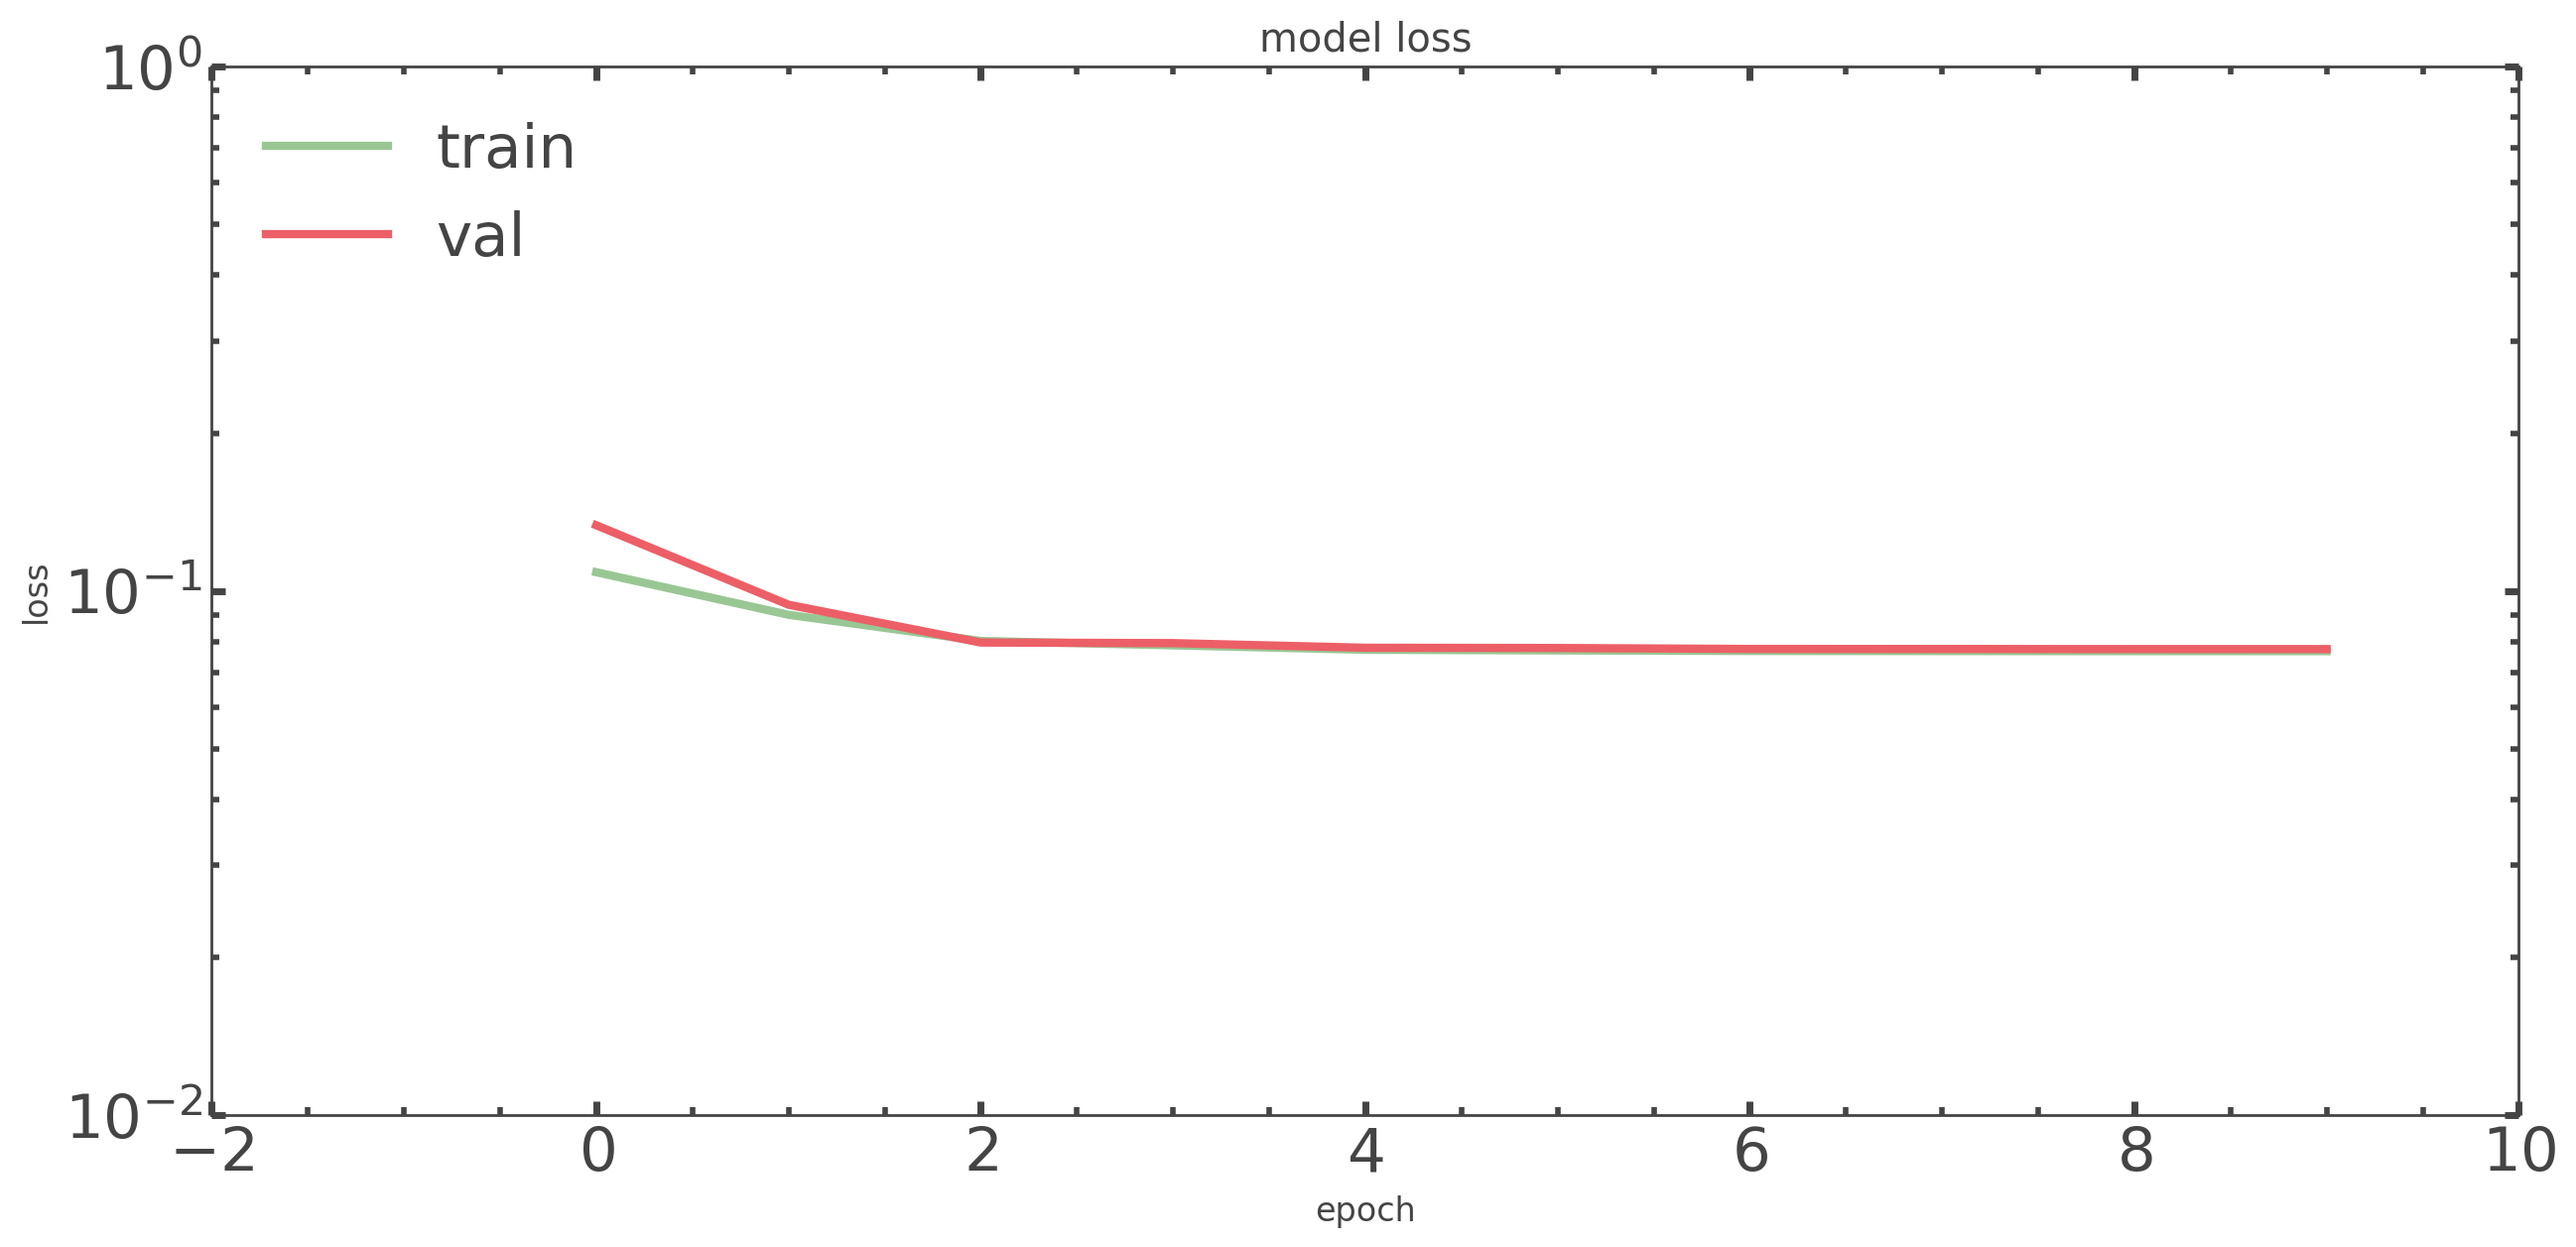

[0.13343653 0.09412061 0.079721   0.07951839 0.07791635 0.07783321
 0.07750909 0.07749959 0.07746148 0.07745839]
[0.10857027 0.090056   0.08028176 0.0787392  0.07724035 0.0770073
 0.07682274 0.07678521 0.07676366 0.07675797]


In [4]:
loss_file = '/fast_scratch_1/jbohm/train_testing_data/train_3/baseline_20230214/losses.npz' 
loss_data = np.load(loss_file, allow_pickle=True)
avg_losses_train = np.mean(loss_data['training'], axis=1)
avg_losses_val = np.mean(loss_data['validation'], axis=1)

auc = roc_auc_score(df["targets_class"], df["outputs_class"])
print('class roc auc score:', auc)

r2 = r2_score(df["targets_regress"], df["outputs_regress"])
print('r2 score:', r2)

# plot loss
fig = plt.figure(figsize=(15,7))
fig.patch.set_facecolor('white')
plt.plot(avg_losses_train)
plt.plot(avg_losses_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 10 epoch, 150 train, 50 val - not being updated after epoch 4 - no improvment in loss??
# 10 epoch, 304 train, 101 val - not being updated much after epoch 6
print(avg_losses_val)
print(avg_losses_train)



Text(0,0.5,'Normalized counts')

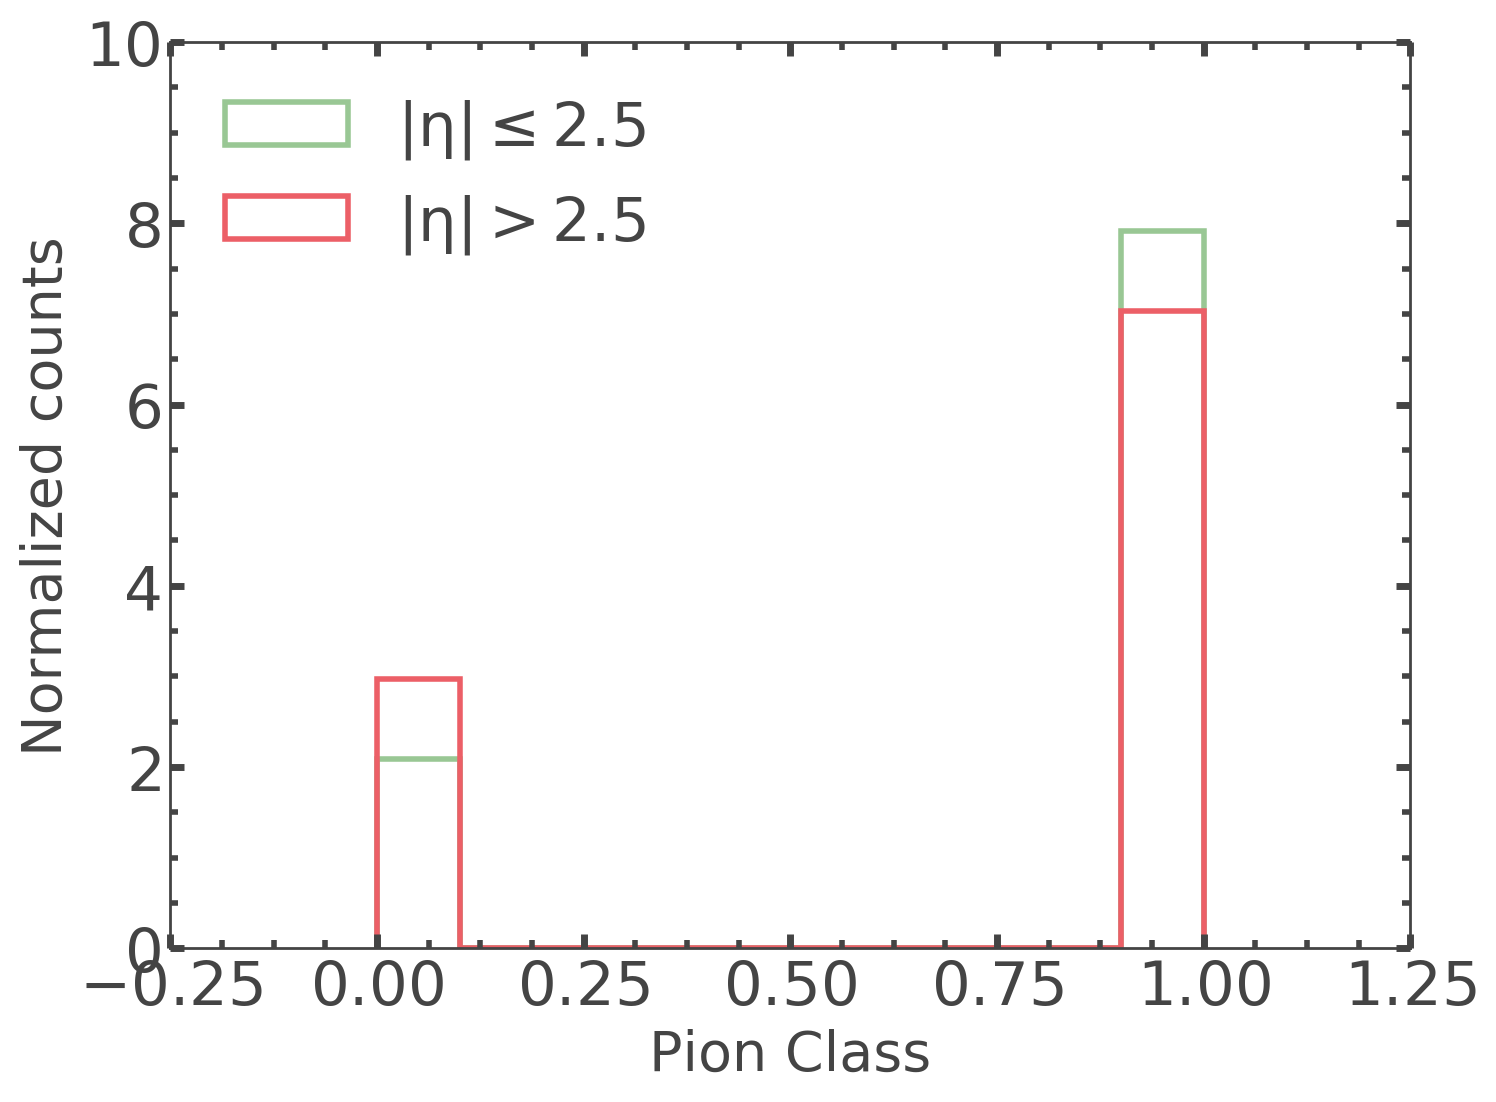

In [5]:
plt.hist(df[np.abs(df.eta) <= 2.5].targets_class, 
         histtype="step", linewidth=2, density=True, label=r"$|\eta| \leq 2.5$");
plt.hist(df[np.abs(df.eta) > 2.5].targets_class, 
         histtype="step", linewidth=2, density=True, label=r"$|\eta| > 2.5$");
plt.legend(loc="upper left")
plt.xlabel("Pion Class", fontsize=20)
plt.ylabel("Normalized counts", fontsize=20)

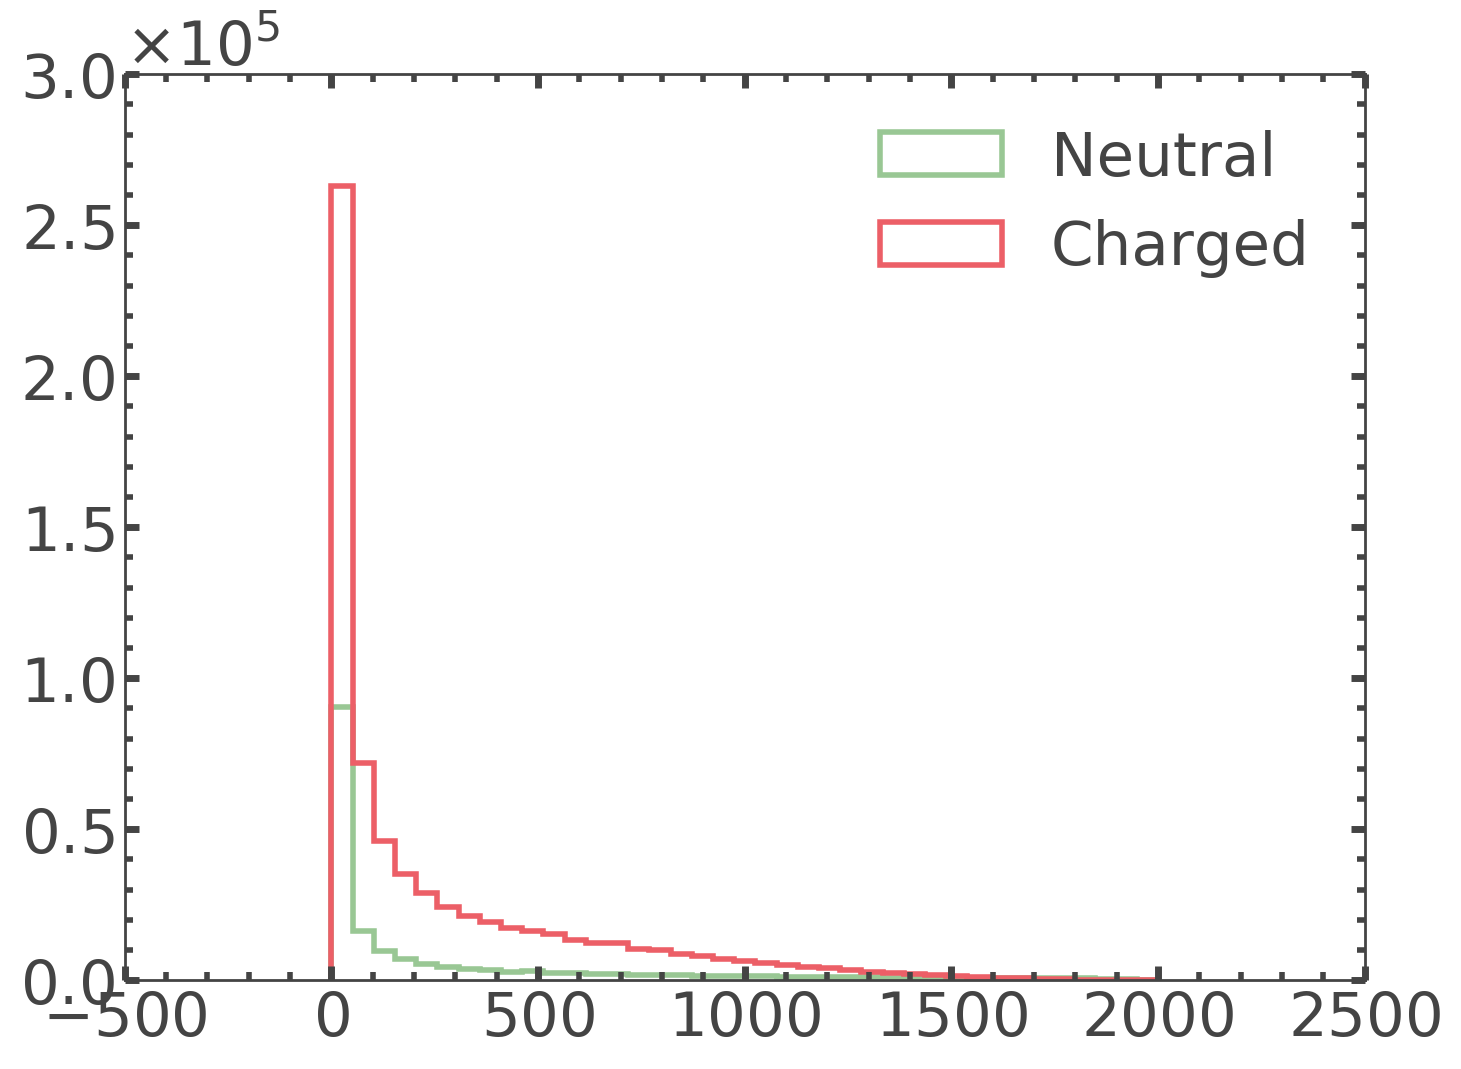

In [6]:
bins=np.linspace(0,2000,40)
plt.hist(df[(df.targets_class == 0) & (np.abs(df.eta) <= 2.5)].energy, 
         bins=bins, density=False, 
         histtype="step", linewidth=2, label="Neutral")
plt.hist(df[(df.targets_class == 1) & (np.abs(df.eta) <= 2.5)].energy, 
         bins=bins, density=False, 
         histtype="step", linewidth=2, label="Charged")
plt.legend()

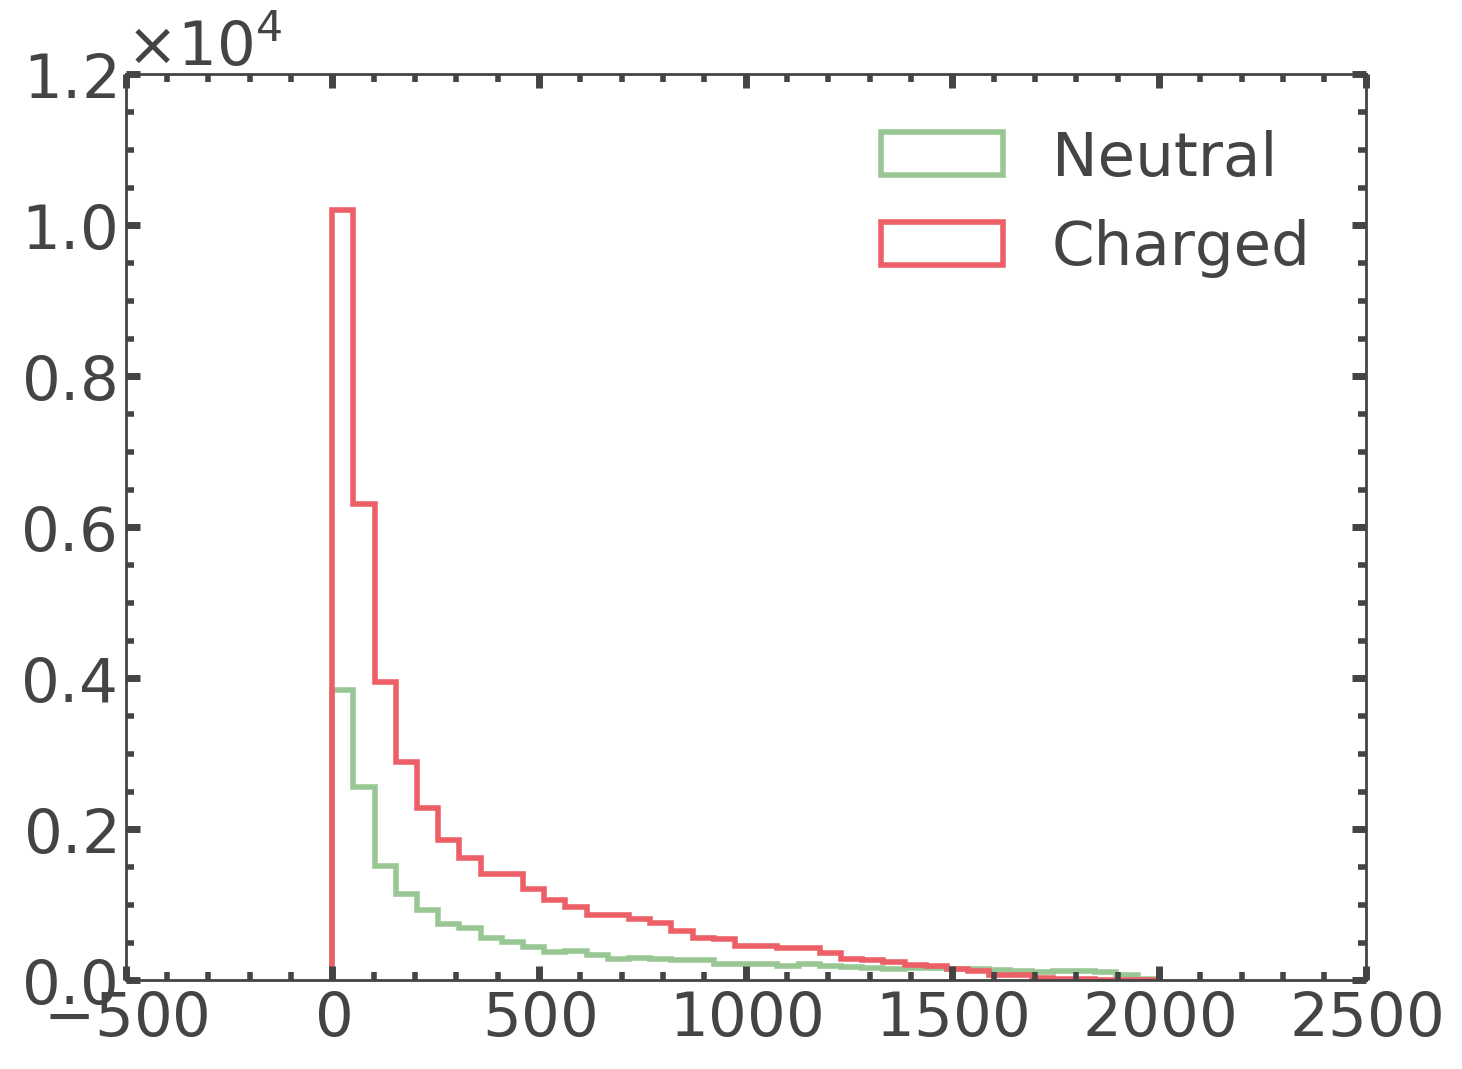

In [7]:
bins=np.linspace(0,2000,40)
plt.hist(df[(df.targets_class == 0) & (np.abs(df.eta) > 2.5)].energy, 
         bins=bins, density=False, 
         histtype="step", linewidth=2, label="Neutral")
plt.hist(df[(df.targets_class == 1) & (np.abs(df.eta) > 2.5)].energy, 
         bins=bins, density=False, 
         histtype="step", linewidth=2, label="Charged")
plt.legend()

In [8]:
def get_rejection(df, eff=0.9):
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    df_roc = pd.DataFrame(np.vstack([tpr,fpr]).T, columns=["tpr","fpr"])
    print("Rejection @ {:.0f}% efficiency: {:.3f}".format(eff*100,1/df_roc[df_roc.tpr > eff].fpr.iloc[0]))
    
def make_classification_plots(df, data_dir=".", save_label="", plot_label="GNN"): 
    ### Bins of energy
    eta_range = "|$\eta$|$<3$"
    plt.figure(figsize=(6,5))
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    fpr_bin0, tpr_bin0, _ = roc_curve(df[df.energy < 1].targets_class, 
                                      df[df.energy < 1].outputs_class)
    fpr_bin1, tpr_bin1, _ = roc_curve(df[(df.energy > 1) & (df.energy < 10)].targets_class, 
                                      df[(df.energy > 1) & (df.energy < 10)].outputs_class)
    fpr_bin2, tpr_bin2, _ = roc_curve(df[(df.energy > 10) & (df.energy < 50)].targets_class, 
                                      df[(df.energy > 10) & (df.energy < 50)].outputs_class)
    fpr_bin3, tpr_bin3, _ = roc_curve(df[(df.energy > 50) & (df.energy < 500)].targets_class, 
                                      df[(df.energy > 50) & (df.energy < 500)].outputs_class)
    plt.plot(tpr, np.nan_to_num(1/fpr),label = "All energies",)
    plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = "50 < $E_{cluster}^{EM}$ $\leq$ 500 GeV",linestyle="dashed")
    plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = "10 < $E_{cluster}^{EM}$ $\leq$ 50 GeV",linestyle="dotted")
    plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = "1 < $E_{cluster}^{EM}$ $\leq$ 10 GeV",linestyle="dashdot")
    plt.plot(tpr_bin0, np.nan_to_num(1/fpr_bin0),label = "$E_{cluster}^{EM}$ $\leq$ 1 GeV")
    plt.xlim(0.5,1)
    plt.yscale('log')
    plt.ylim(0,5000)
    plt.tick_params(labelsize=14)
    ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency");
    ampl.set_ylabel(r"$\pi^0$ Rejection");
    
    ### if GNN
    if save_label == "gnn": 
        plt.legend(loc="lower left", fontsize=9, handlelength=4);
        ampl.plot.draw_atlas_label(0.5,0.95, status='prelim', simulation=True, 
                                   desc=r"GNN Classification of $\pi^{\pm}$ vs. $\pi^0$ "+"\n"+"Single Pion MC, Topo-clusters, "+eta_range)
    
    ### if PFN
    elif save_label == "pfn":
        plt.legend(loc="upper right", fontsize=9, handlelength=4);
        ampl.plot.draw_atlas_label(0.05,0.18, status='prelim', simulation=True, 
                               desc=r"DeepSets/PFN Classification of $\pi^{\pm}$ vs. $\pi^0$ "+"\n"+"Single Pion MC, Topo-clusters, "+eta_range)
        
    #plt.savefig(data_dir+'/'+save_label+'_energy_bins.png', bbox_inches='tight')
    #plt.savefig(data_dir+'/'+save_label+'_energy_bins.pdf', bbox_inches='tight')
    
    # ### Bins of eta
    plt.figure(figsize=(6,5))
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    fpr_bin0, tpr_bin0, _ = roc_curve(df[np.abs(df.eta) < 0.8].targets_class, 
                                      df[np.abs(df.eta) < 0.8].outputs_class)
    fpr_bin1, tpr_bin1, _ = roc_curve(df[(np.abs(df.eta) > 0.8) & (np.abs(df.eta) < 1.37)].targets_class, 
                                      df[(np.abs(df.eta) > 0.8) & (np.abs(df.eta) < 1.37)].outputs_class)
    fpr_bin2, tpr_bin2, _ = roc_curve(df[(np.abs(df.eta) > 1.37) & (np.abs(df.eta) < 2.5)].targets_class, 
                                      df[(np.abs(df.eta) > 1.37) & (np.abs(df.eta) < 2.5)].outputs_class)
    fpr_bin3, tpr_bin3, _ = roc_curve(df[np.abs(df.eta) > 2.5].targets_class, 
                                      df[np.abs(df.eta) > 2.5].outputs_class)
    plt.plot(tpr, np.nan_to_num(1/fpr),label = "All $\eta$ values",)
    plt.plot(tpr_bin0, np.nan_to_num(1/fpr_bin0),label = "$|\eta|$ $\leq$ 0.8",linestyle="dotted")
    plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = "0.8 < $|\eta|$ $\leq$ 1.37",linestyle="dashdot")
    plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = "1.37 < $|\eta|$ $\leq$ 2.5",)
    plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = "$|\eta|$ > 2.5",linestyle="dashed")
    plt.xlim(0.7,1)
    plt.yscale('log')
    plt.ylim(0,1000)
    plt.tick_params(labelsize=14)
    ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency");
    ampl.set_ylabel(r"$\pi^0$ Rejection");
    ### if GNN
    if save_label == "gnn": 
        plt.legend(loc="lower left", fontsize=11, handlelength=4);
        ampl.plot.draw_atlas_label(0.5,0.95, status='prelim', simulation=True, 
                                   desc=r"GNN Classification of $\pi^{\pm}$ vs. $\pi^0$ "+"\n"+"Single Pion MC, Topo-clusters, "+eta_range)
    ### if PFN
    elif save_label == "pfn":
        plt.legend(loc="upper right", fontsize=11, handlelength=4);
        ampl.plot.draw_atlas_label(0.05,0.2, status='prelim', simulation=True, 
                               desc=r"DeepSets/PFN Classification of $\pi^{\pm}$ vs. $\pi^0$ "+"\n"+"Single Pion MC, Topo-clusters, "+eta_range)
    #plt.savefig(data_dir+'/'+save_label+'_eta_bins.png', bbox_inches='tight')
    #plt.savefig(data_dir+'/'+save_label+'_eta_bins.pdf', bbox_inches='tight')

def make_response_plot(y_true, y_pred, y_ratio, pion_label, f_name=''):
    p_r = pearsonr(y_true,y_pred)[0]
    s_r = spearmanr(y_true,y_pred)[0]
    mse = mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print("r2:{:.3f}".format(r2))
    print("PearsonR:{:.3f}, SpearmanR:{:.3f}, MSE:{:.3f}, MAE:{:.3f}".
          format(p_r, s_r, mse, mae))
    xcenter, medRegCNN = ru.responsePlot(y_true, y_ratio,
                                         figfile = f_name,
                                         statistic = 'median',
                                         atlas_x = 0.55, atlas_y = 0.95, simulation = True,
                                         textlist = [{'x': 0.55, 'y': 0.85, 'text': pion_label}])
    return xcenter, medRegCNN

def make_regression_plots(df, label="", data_dir=".", charged_pions_only=False):
    c_map = sns.color_palette("viridis")

    if charged_pions_only:
        pion_list = ['$\pi^{\pm}$']
        sym_list = ['+-']
        labels = [r'$\pi^{\pm}$']
    else: 
        pion_list = ['$\pi^{all}$', '$\pi^{0}$', '$\pi^{\pm}$']
        sym_list = ['', '0', '+-']
        labels = [r'$\pi^{all}$', r'$\pi^{0}$', r'$\pi^{\pm}$']
                
    blues = matplotlib.cm.viridis(np.linspace(0,1,20))
    oranges = matplotlib.cm.viridis(np.linspace(0,1,20))

    response_median = []

    print('\nPlotting {}'.format(pion_list[0]))
    y_true =  df.targets_regress
    y_pred = df.outputs_regress
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[0], 
                                            f_name=data_dir+'/regress_'+label+'_all.pdf')
    response_median.append(medRegCNN)
    
    if not charged_pions_only:
        if "targets_class" in df.keys():
            print('\nPlotting {}'.format(pion_list[1]))
            y_true = df.targets_regress[df.targets_class==0]
            y_pred = df.outputs_regress[df.targets_class==0]
            xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[1],
                                                   f_name=data_dir+'/regress_'+label+'_pi0.pdf')
            response_median.append(medRegCNN)

            print('\nPlotting {}'.format(pion_list[2]))
            y_true = df.targets_regress[df.targets_class==1]
            y_pred = df.outputs_regress[df.targets_class==1]
            y_ratio = df.outputs_regress/df.targets_regress
            xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[2],
                                                   f_name=data_dir+'/regress_'+label+'_pion.pdf')
            response_median.append(medRegCNN)

    #np.savez(data_dir+'/response_medians_'+label+'.npz', response_median=response_median, xcenter=xcenter)
    
    ### Response medians 
    pu.lineOverlay(xcenter=xcenter, lines=response_median,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = labels,
                xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response Median',
                figfile = '',
                y_max=1.2, y_min=.9, 
                   x_min = 0,#.3, 
                   colorgrouping=0,
                extra_lines= [[[0, 10e3], [1, 1]]],
                linestyles = ['solid', 'solid', 'solid'],
                atlas_x = 0.05, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $\pi^{\pm}$'},
                            {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'}])

    ### IQR Plots
    iqr = []
    print('\nPlotting {}'.format(pion_list[0]))
    y_true = df.targets_regress # df.truth_particle_e
    y_ratio = df.outputs_regress/df.targets_regress
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
    iqr.append(iqr_curr)
    
    if not charged_pions_only:
        if "targets_class" in df.keys():
            print('\nPlotting {}'.format(pion_list[1]))
            y_true = df.targets_regress[df.targets_class==0]
            y_pred = df.outputs_regress[df.targets_class==0]
            y_ratio = y_pred/y_true
            xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
            iqr.append(iqr_curr)

            print('\nPlotting {}'.format(pion_list[2]))
            y_true = df.targets_regress[df.targets_class==1]
            y_pred = df.outputs_regress[df.targets_class==1]
            y_ratio = y_pred/y_true
            xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
            iqr.append(iqr_curr)
        
    #np.savez(data_dir+'/iqr_'+label+'.npz', iqr=iqr, xcenter=xcenter)
    pu.lineOverlay(xcenter=xcenter, lines = iqr,  
                labels = labels,
                xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
                y_max = 0.5,  # default = 0.5
                   x_min = 0, #.3,
                linestyles = [
                    'solid', 
                    'solid', 
                    'solid'
                ],  
                atlas_x = 0.5, atlas_y = 0.675, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.575, 'text': 'Single $pions$'},
                            {'x': 0.5, 'y': 0.525,  'text': 'Regression Comparison'}],
                  figfile='')

/tmp/ipykernel_50263/3703606827.py:19: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, np.nan_to_num(1/fpr),label = "All energies",)
/home/jbohm/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2536: RuntimeWarning: overflow encountered in double_scalars
  x1t += delta
/tmp/ipykernel_50263/3703606827.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = "50 < $E_{cluster}^{EM}$ $\leq$ 500 GeV",linestyle="dashed")
/tmp/ipykernel_50263/3703606827.py:21: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = "10 < $E_{cluster}^{EM}$ $\leq$ 50 GeV",linestyle="dotted")
/tmp/ipykernel_50263/3703606827.py:22: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = "1 < $E_{cluster}^{EM}$ $\leq$ 10 GeV",linestyle="dashdot")
/tmp/ipykernel_50263/3703606827.py:23: RuntimeWarning: divide by zero encoun

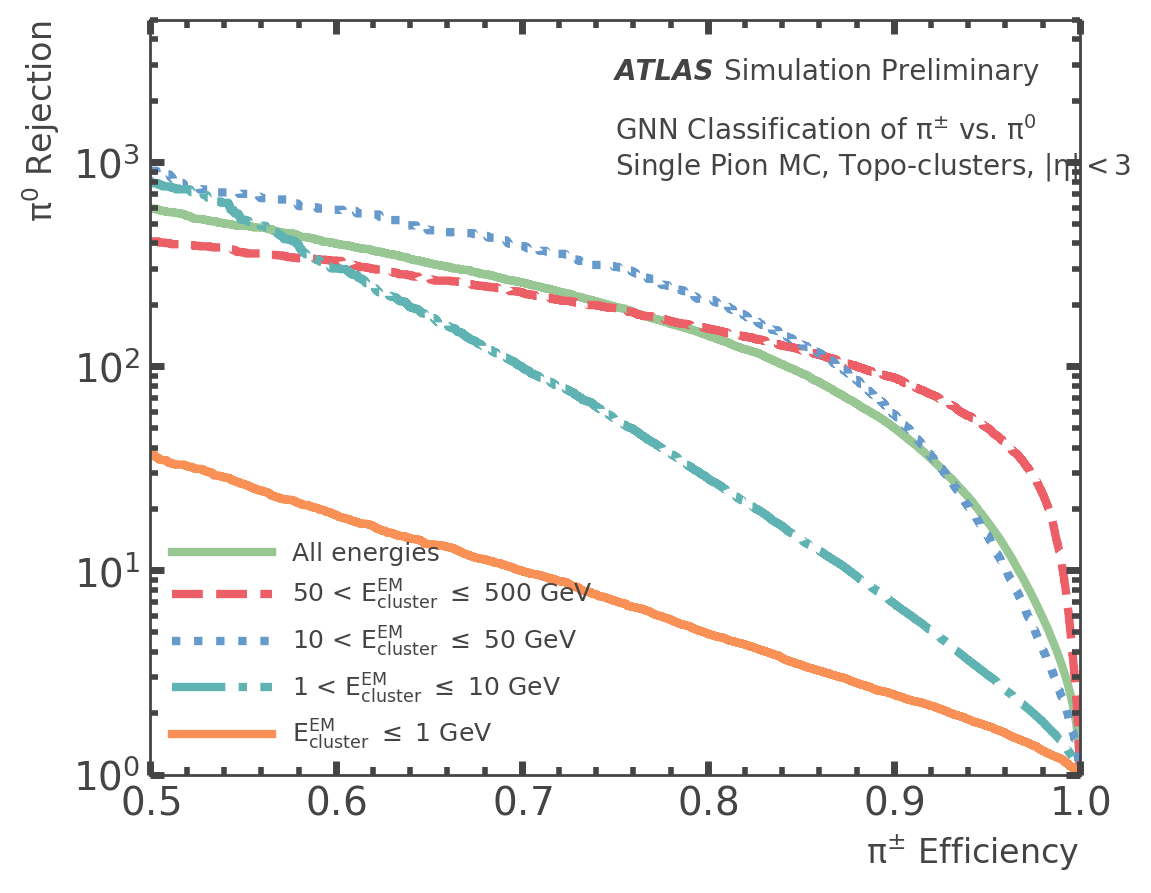

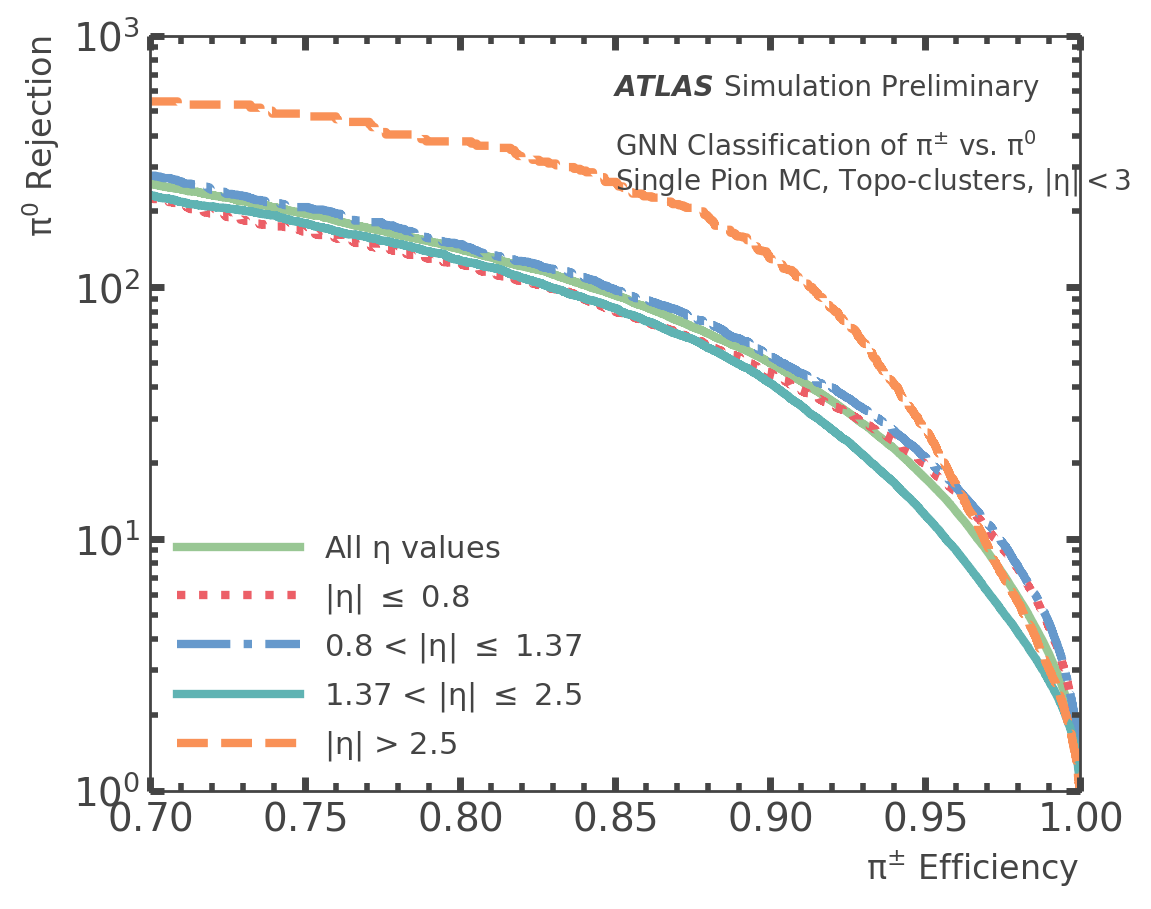

In [9]:
make_classification_plots(df, 
                          data_dir="./pub_note_results", 
                          save_label="gnn", 
                          plot_label="GNN")


Plotting $\pi^{all}$
r2:0.988
PearsonR:0.994, SpearmanR:0.996, MSE:1.663, MAE:0.546
Saving figure to ./regress_gnn_clusteronly_all.pdf


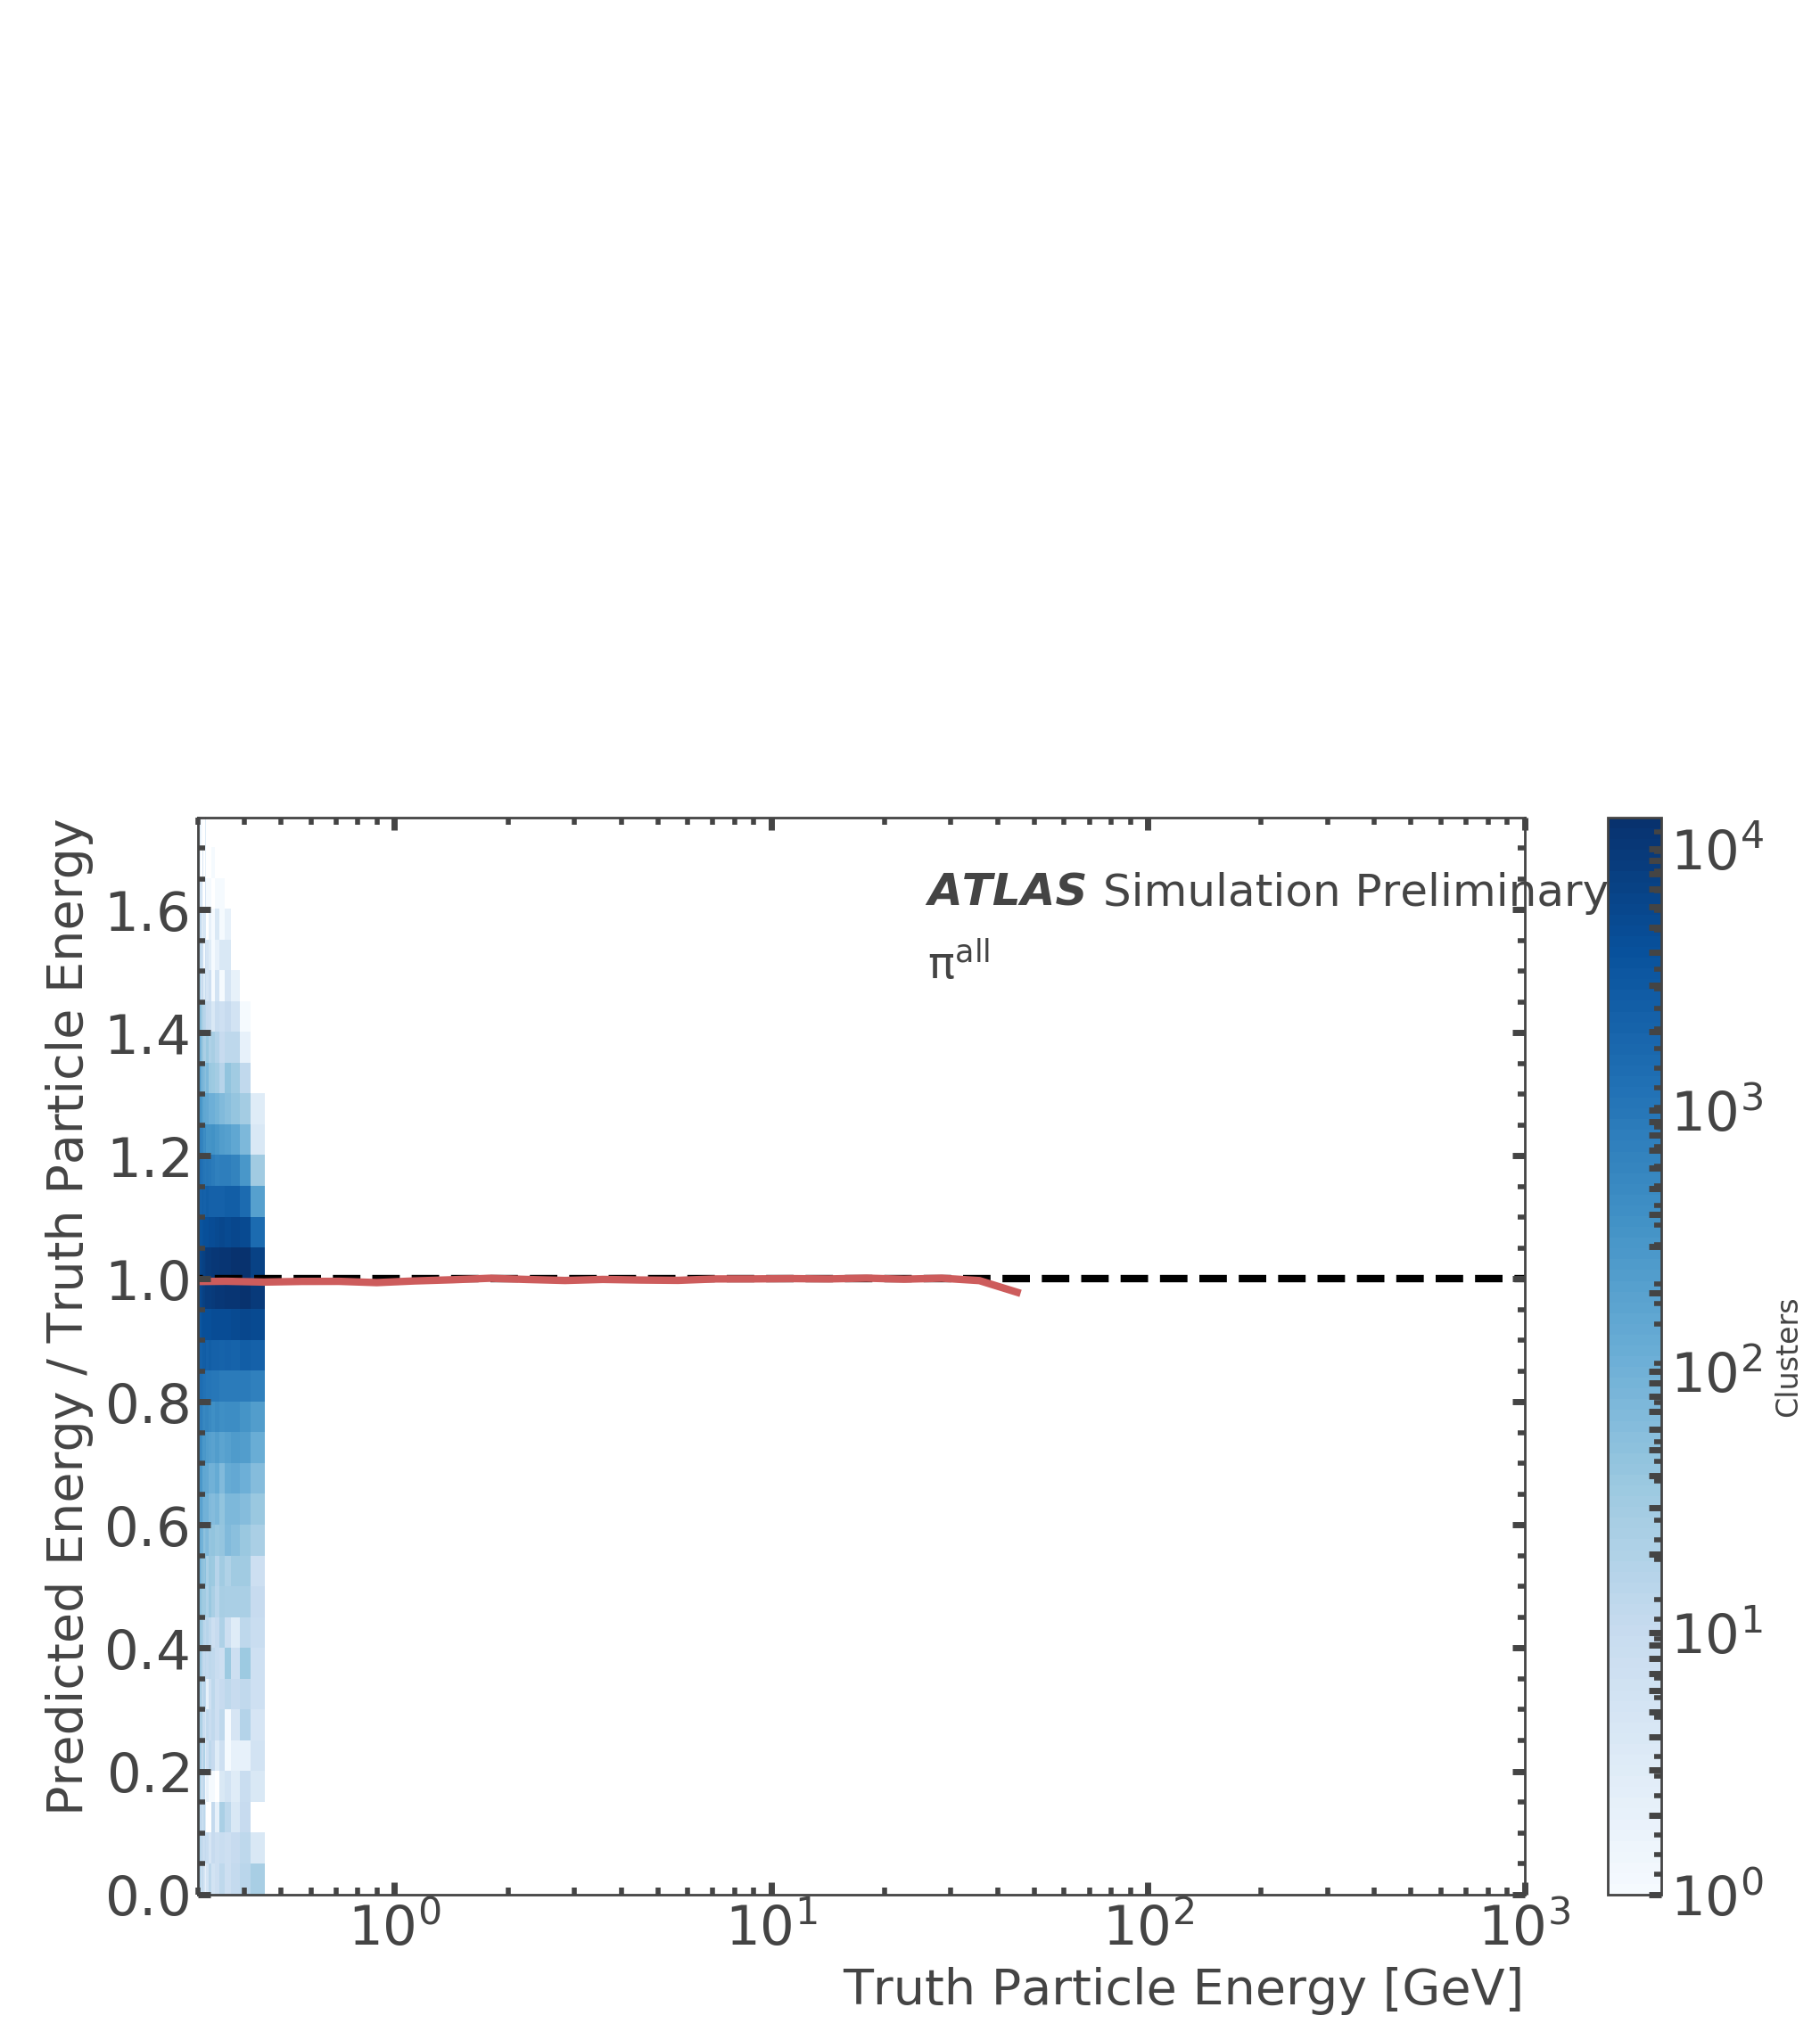


Plotting $\pi^{0}$
r2:0.997
PearsonR:0.998, SpearmanR:0.998, MSE:0.372, MAE:0.185
Saving figure to ./regress_gnn_clusteronly_pi0.pdf


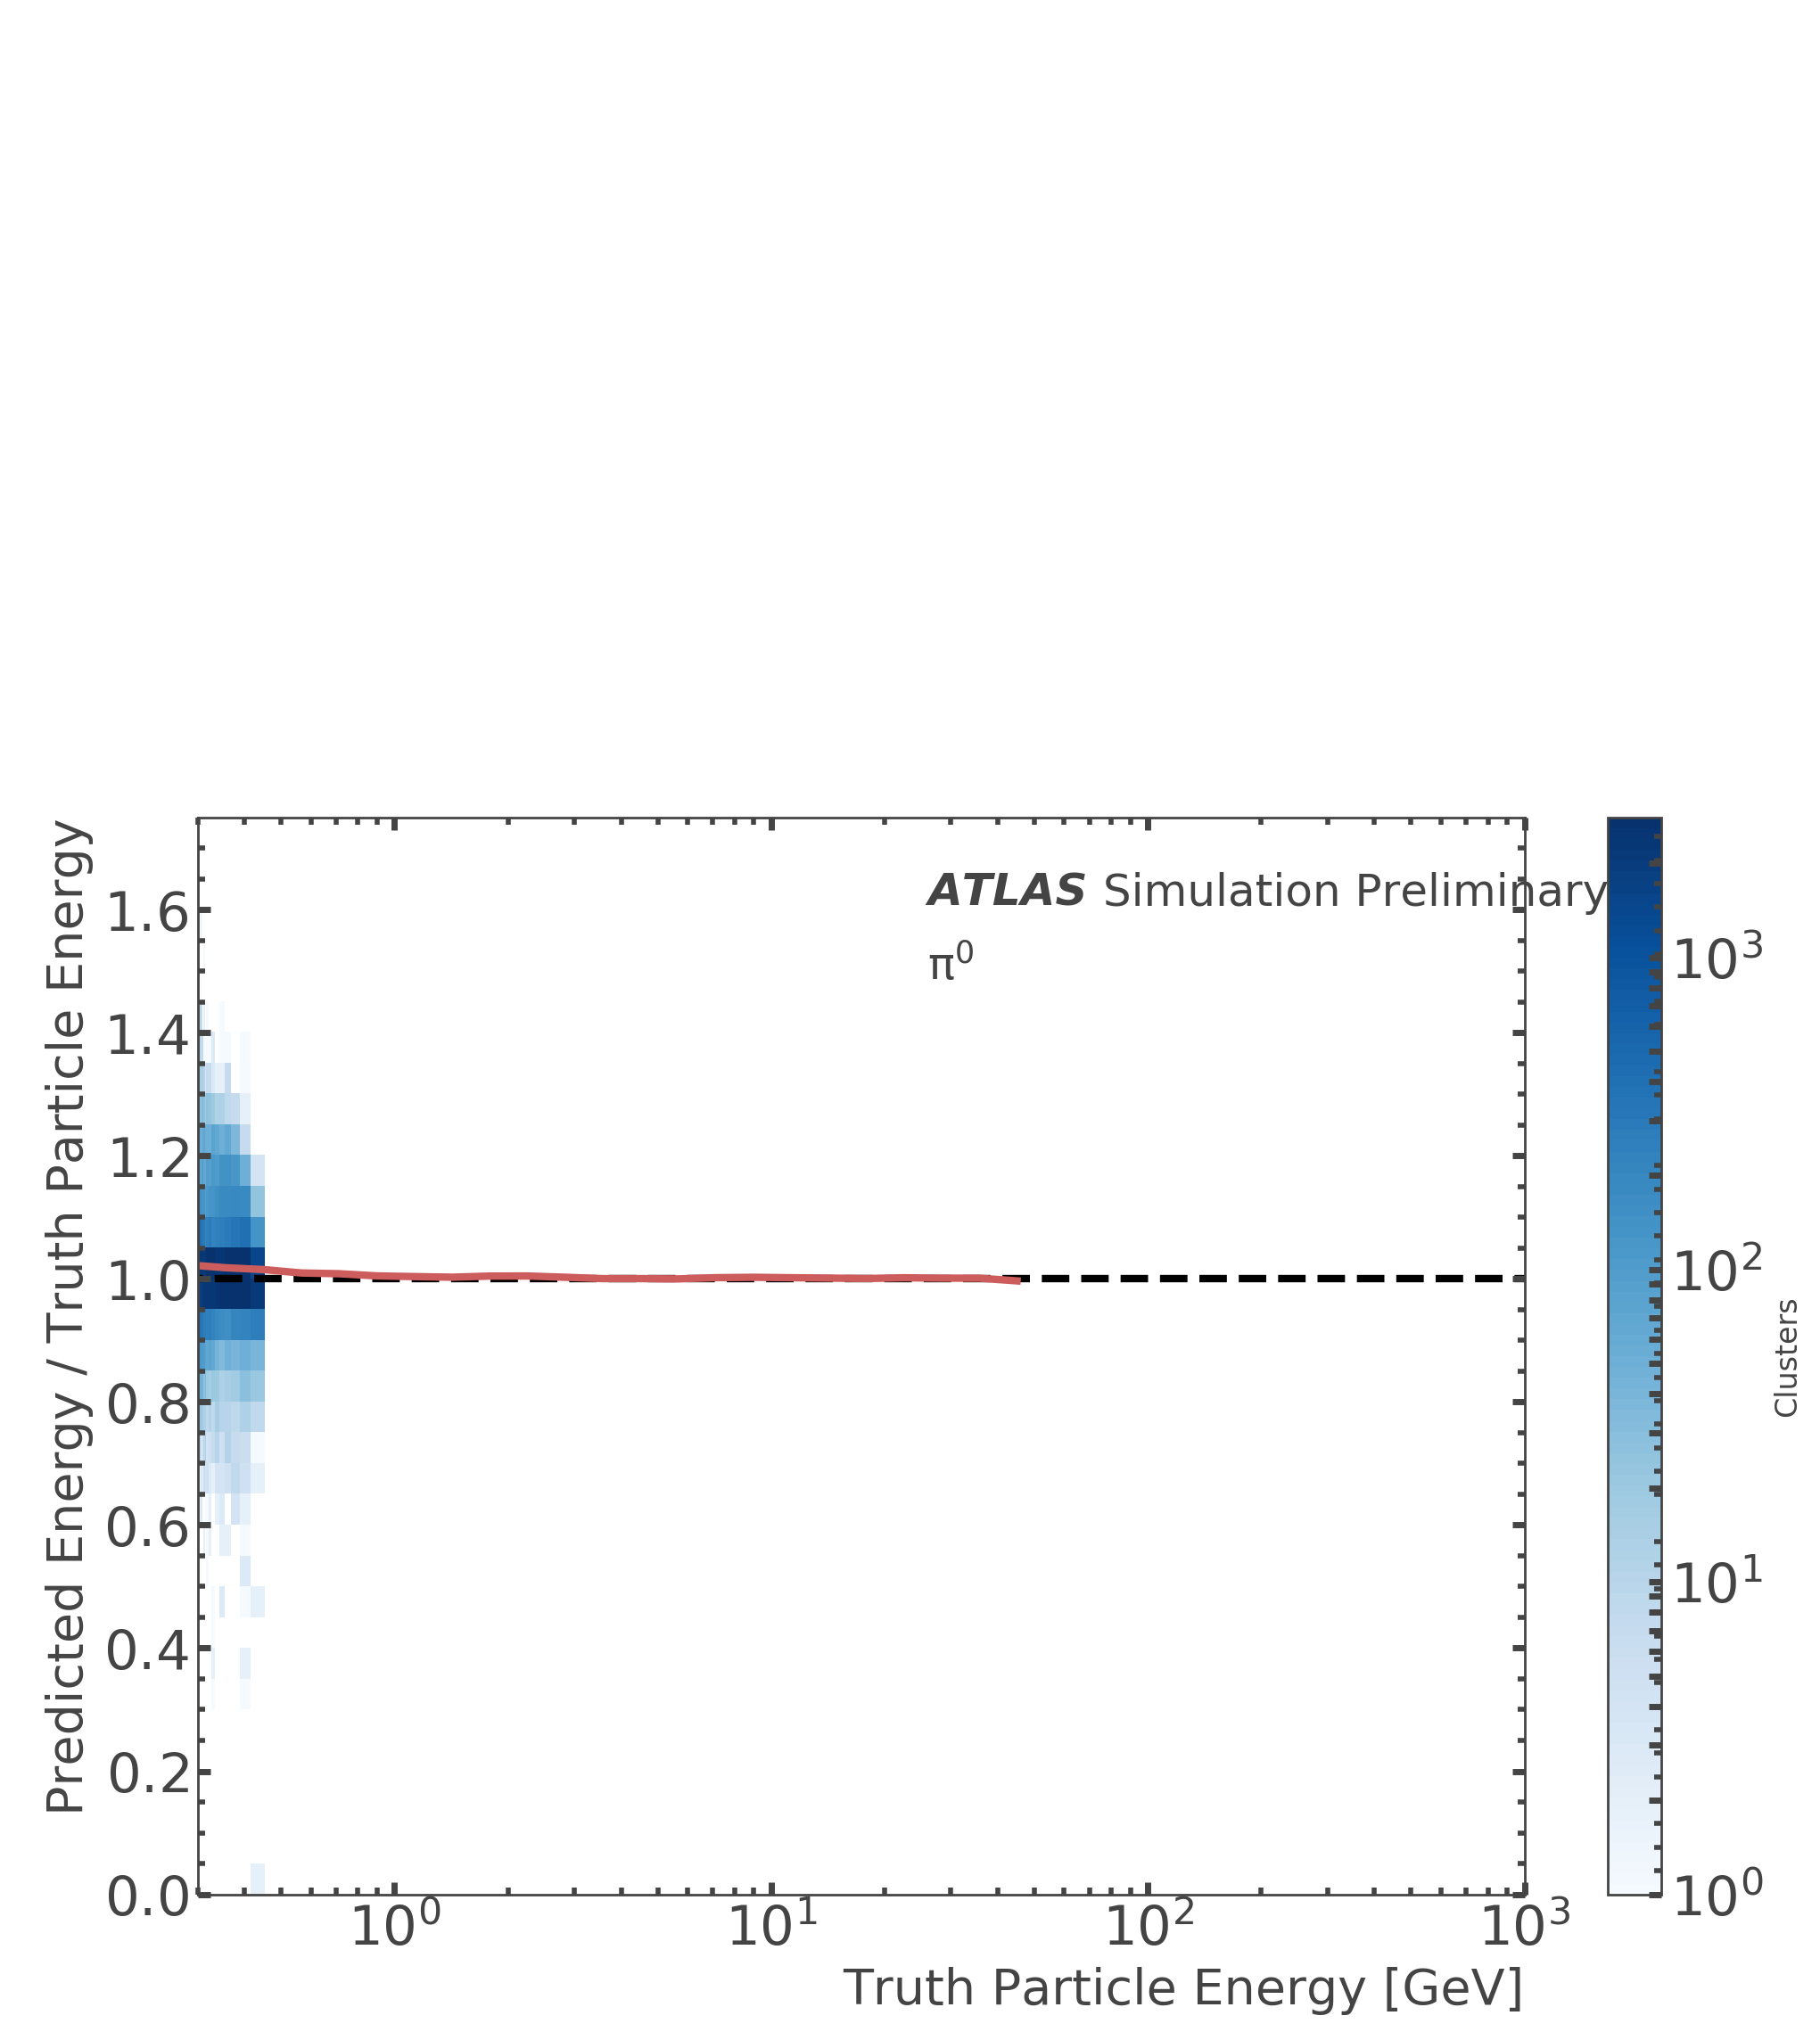


Plotting $\pi^{\pm}$
r2:0.986
PearsonR:0.993, SpearmanR:0.995, MSE:2.016, MAE:0.645
Saving figure to ./regress_gnn_clusteronly_pion.pdf


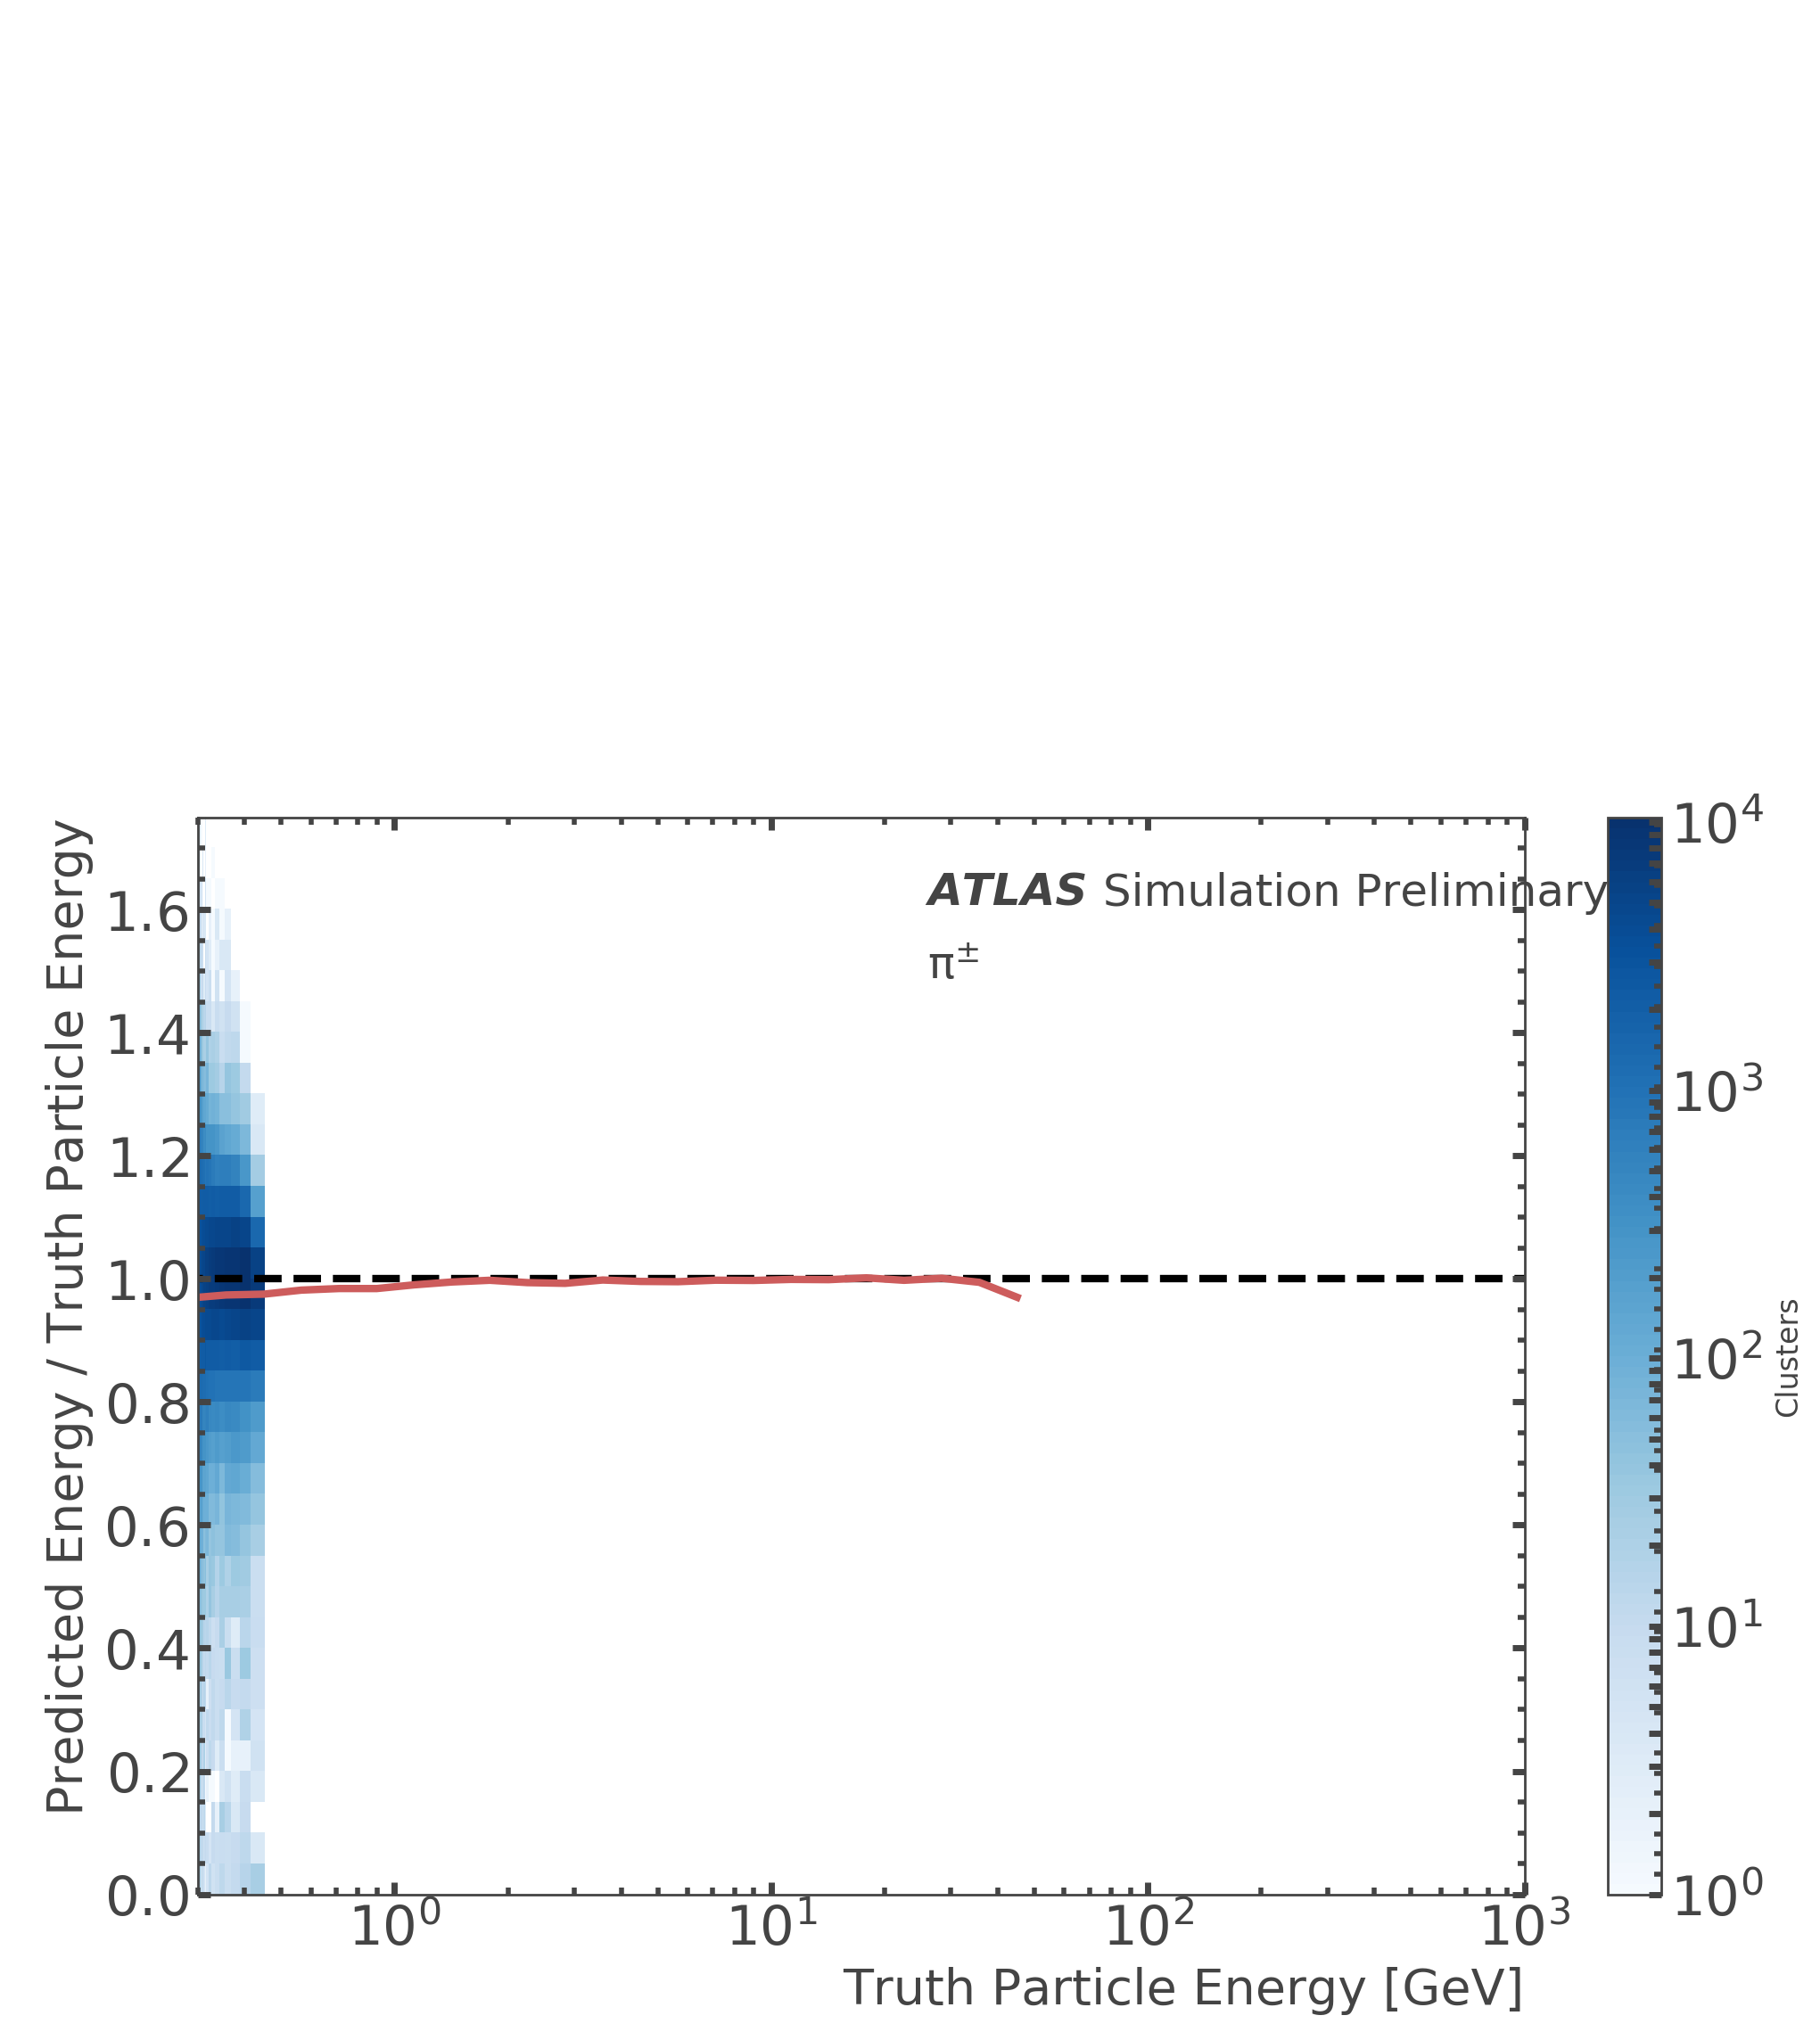

extra_line [[0, 10000.0], [1, 1]]
['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/home/jbohm/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:3156: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  warnings.warn(


<Figure size 1600x1200 with 0 Axes>

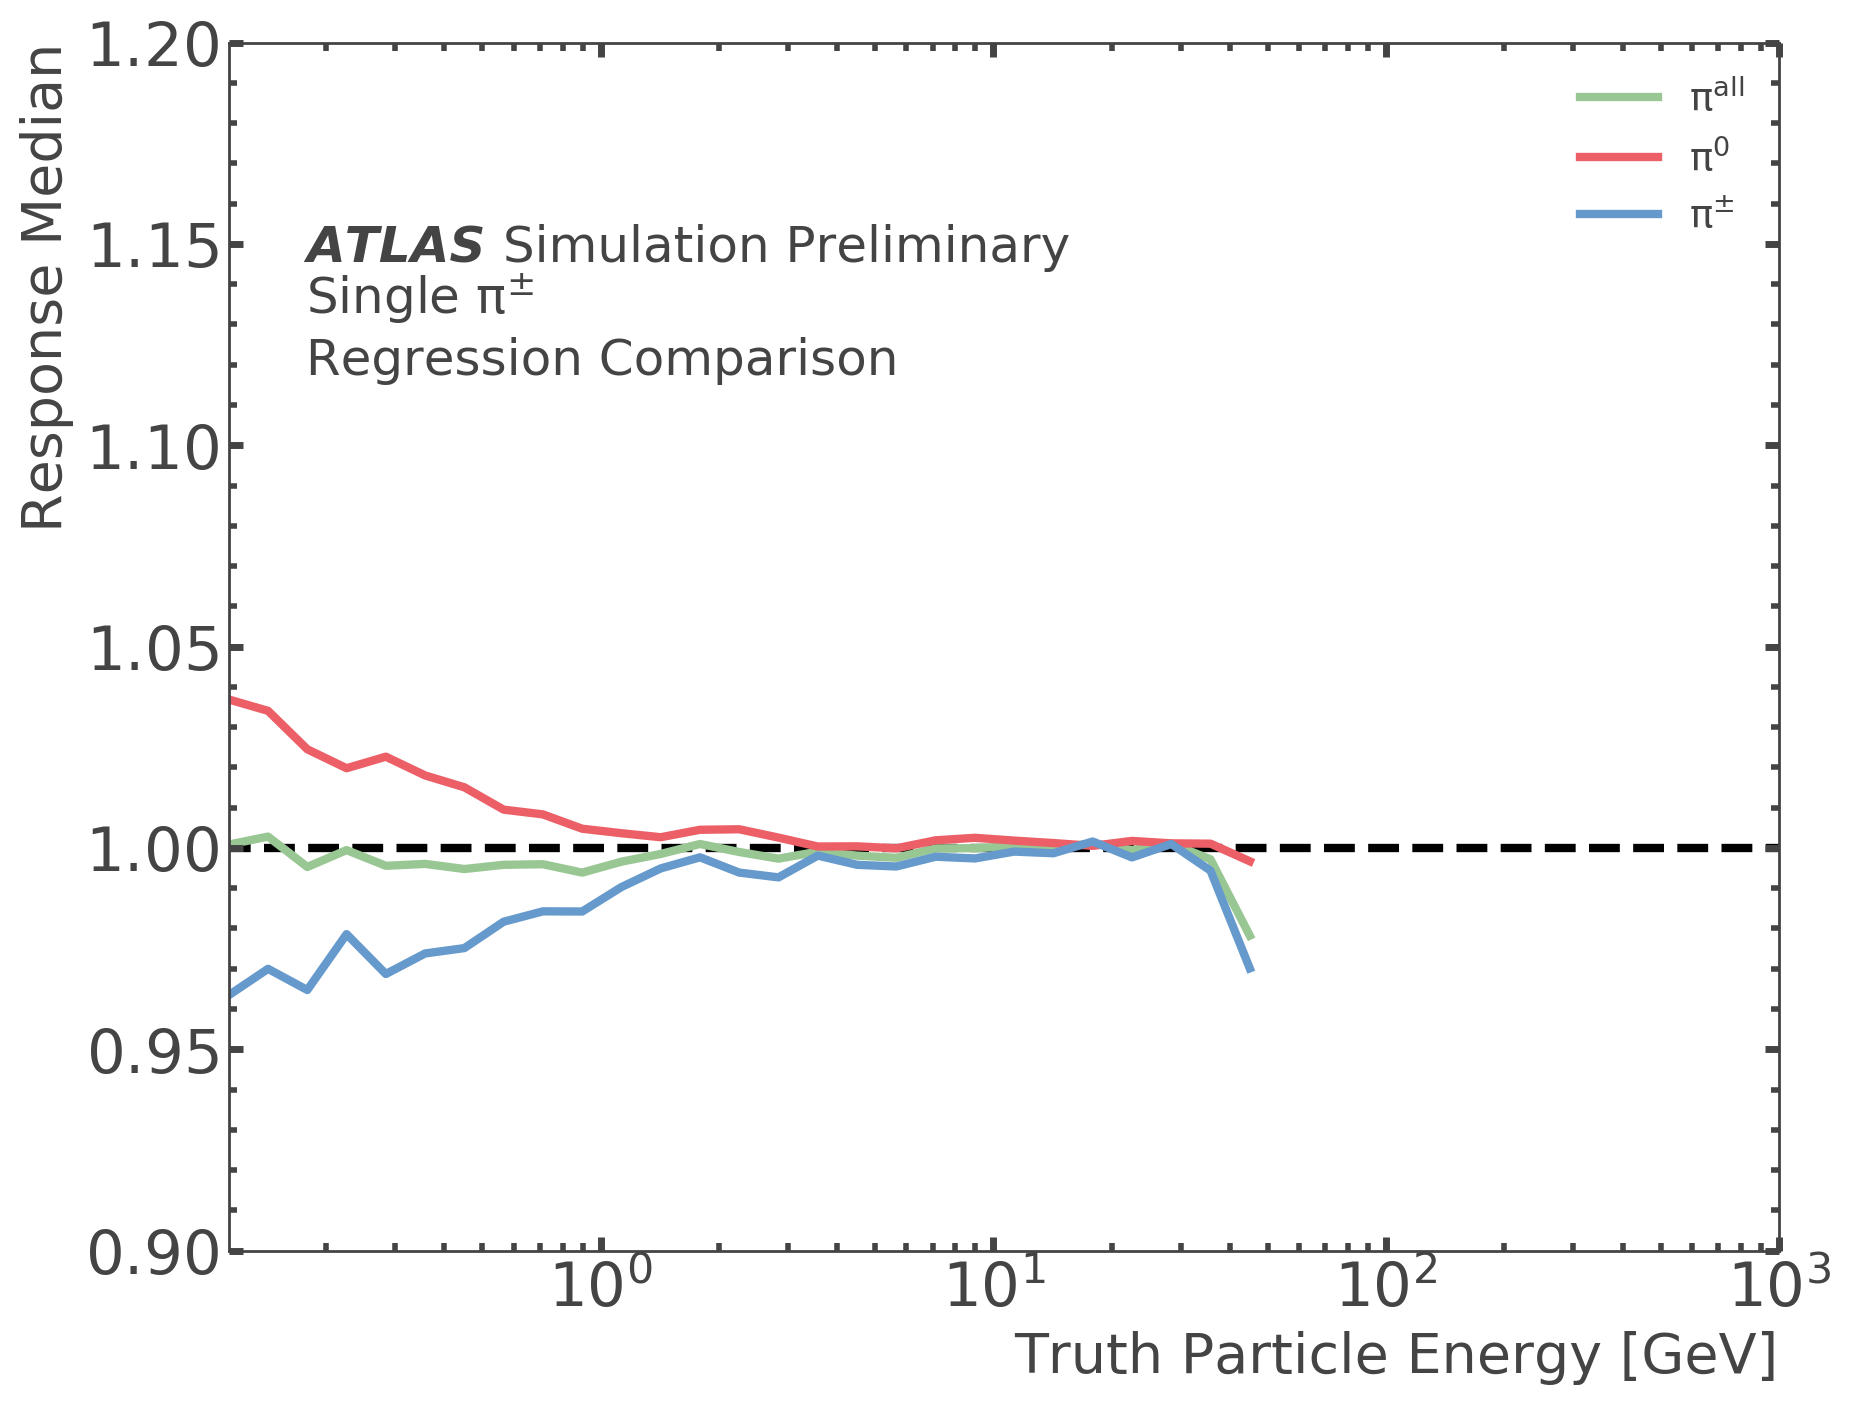


Plotting $\pi^{all}$


<Figure size 1600x1200 with 0 Axes>

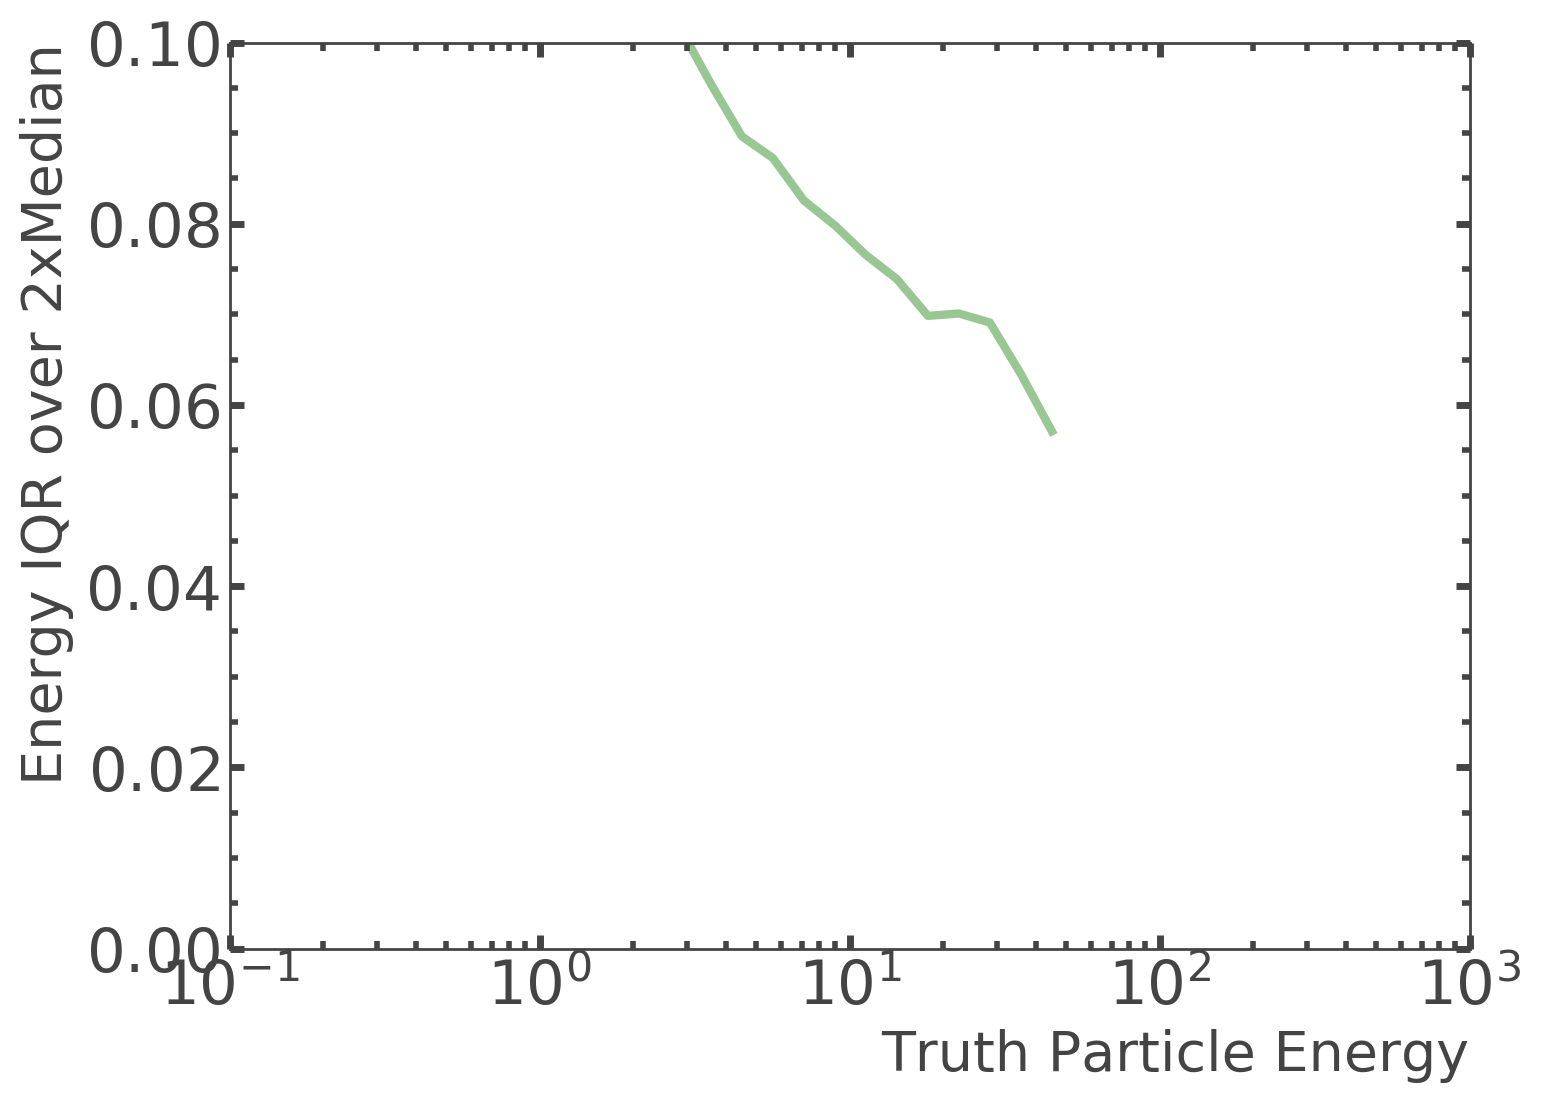


Plotting $\pi^{0}$


<Figure size 1600x1200 with 0 Axes>

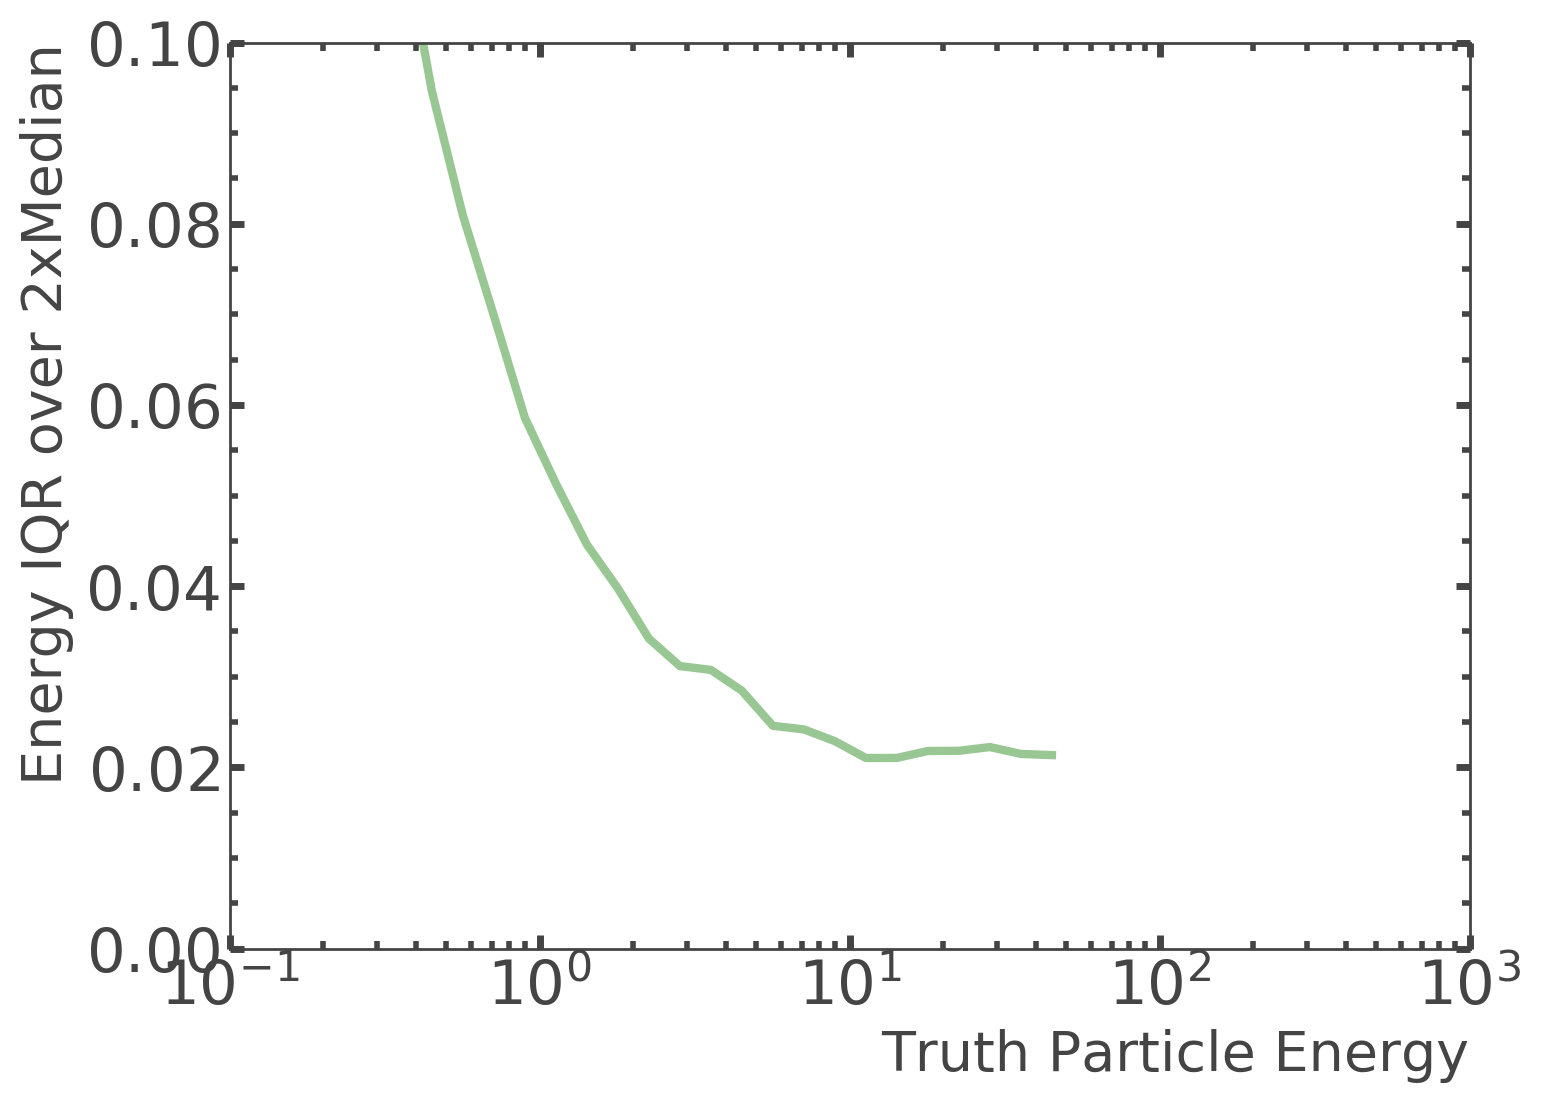


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

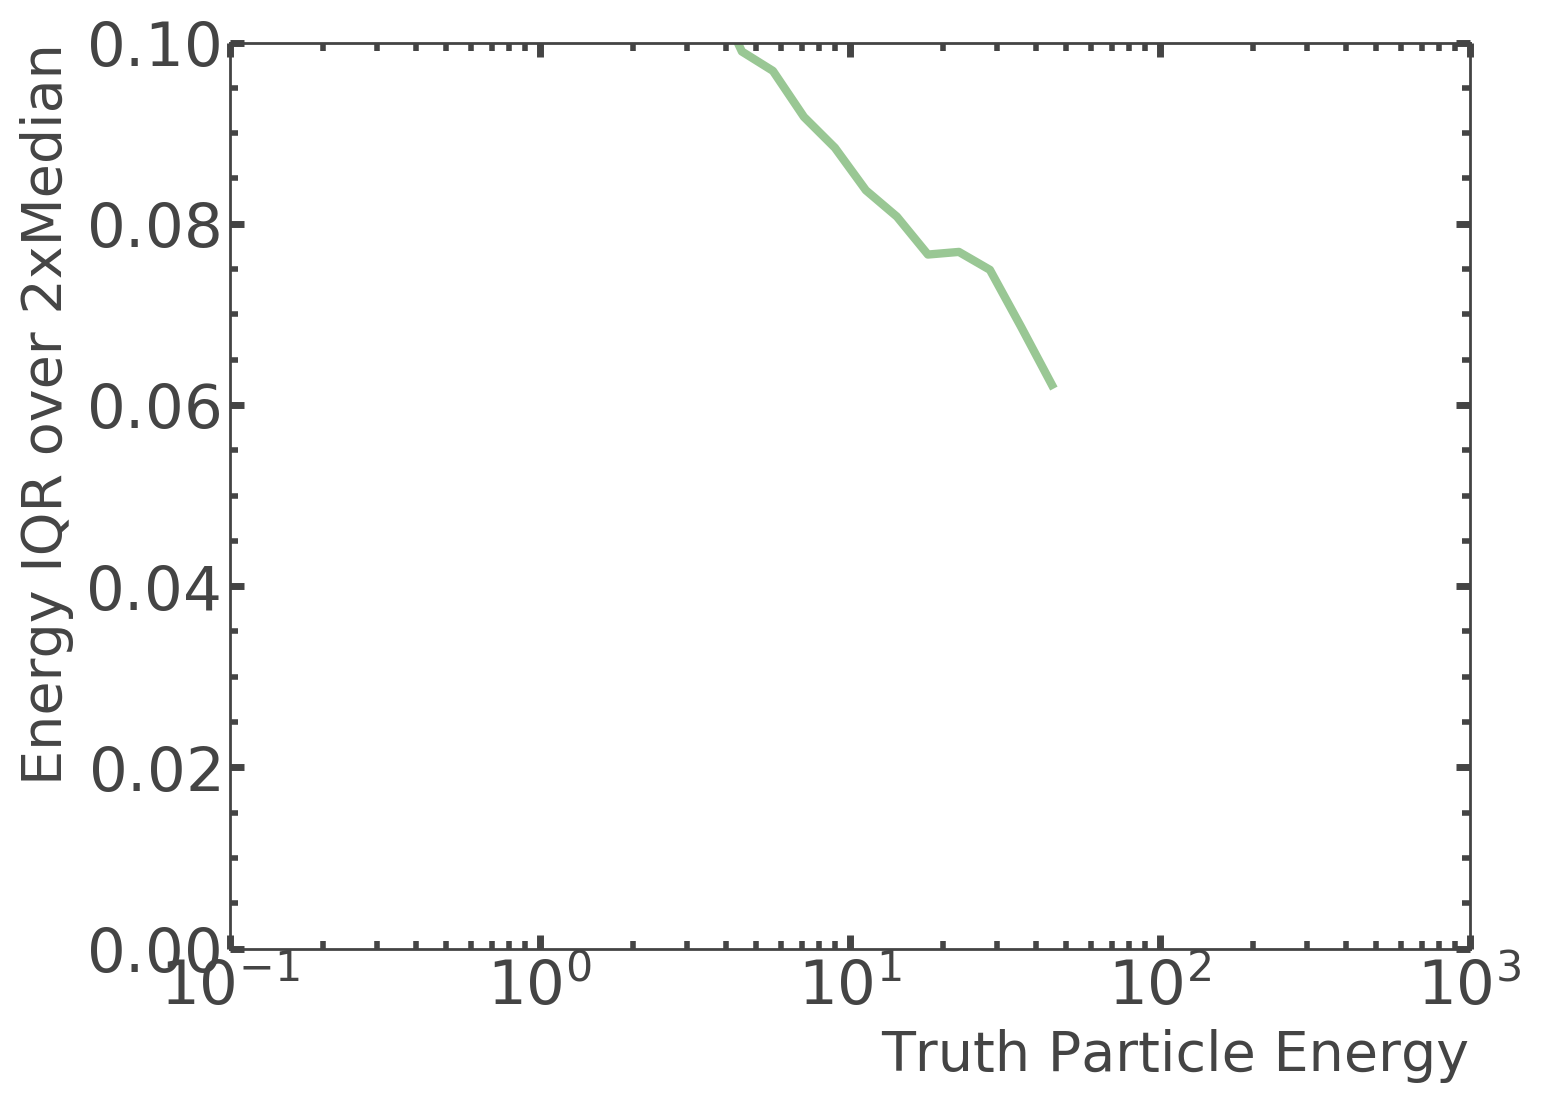

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/home/jbohm/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:3156: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  warnings.warn(


<Figure size 1600x1200 with 0 Axes>

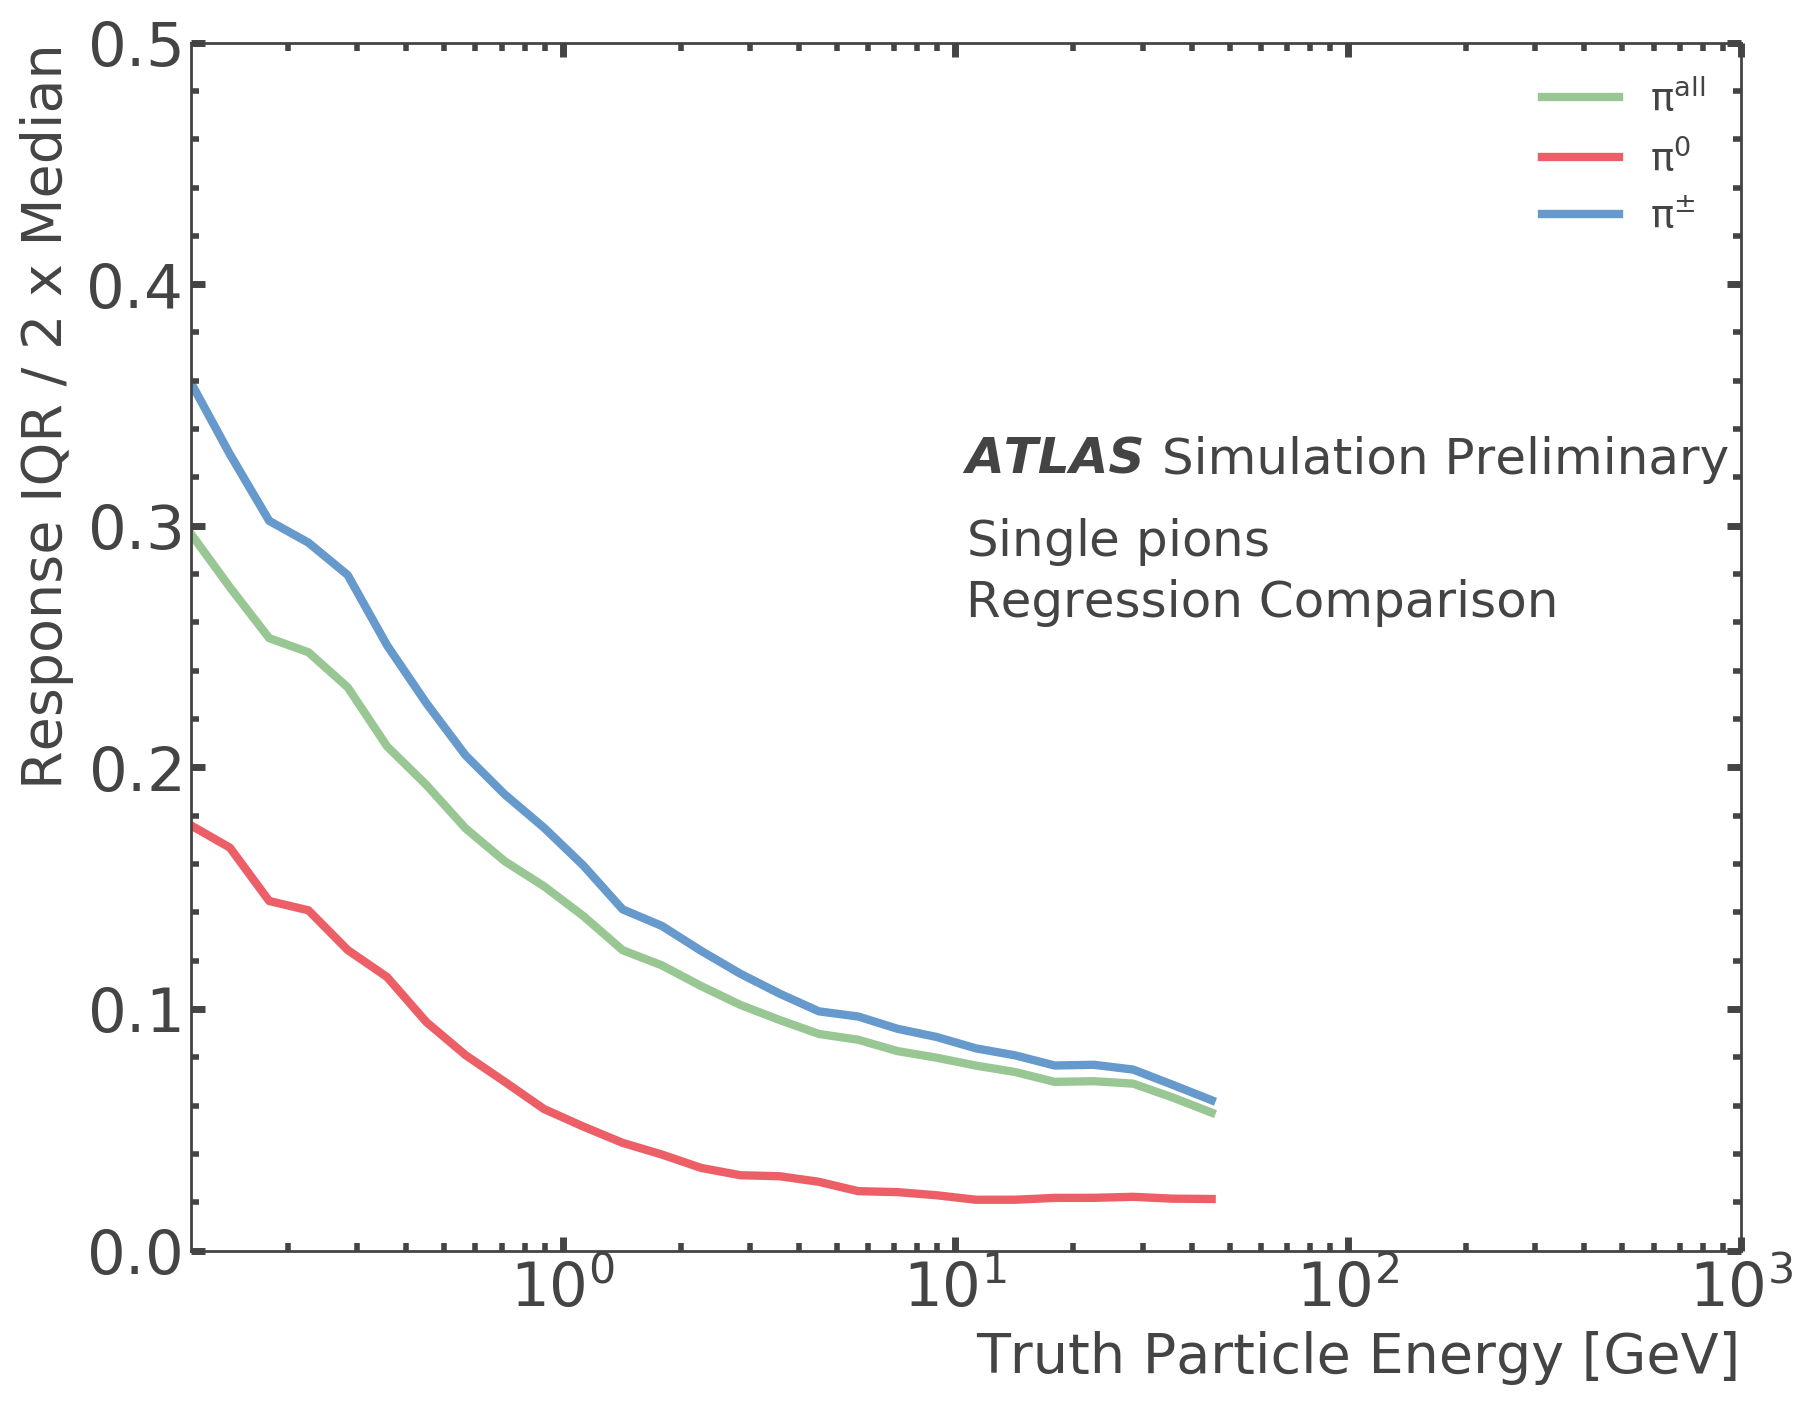

In [10]:
### GNN Cluster-only 
make_regression_plots(df, 
    charged_pions_only = False,
    label="gnn_clusteronly",
    )

In [ ]:
### All pions 
iqr_gnn = np.load('pub_note_results/iqr_gnn_clusteronly.npz')
iqr_pfn = np.load('pub_note_results/iqr_pfn_clusteronly.npz')
iqr_em =  np.load('pub_note_results/iqr_clusteronly_em.npz')
iqr_lcw =  np.load('pub_note_results/iqr_clusteronly_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = iqr_gnn['xcenter']

iqr_2 = [
    iqr_em['iqr'][0,:],
    iqr_lcw['iqr'][0,:],
    iqr_gnn['iqr'][0,:],
      ]

labels=['EM', 'LCW', 'GNN', ]

pu.lineOverlay(xcenter=xcenter, lines = iqr_2,  
            labels = labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
            y_max = 0.5,  
               x_min = .3,
            linestyles = ['dashed','dashed','solid','solid','solid','solid'],  
            atlas_x = 0.45, atlas_y = 0.7, simulation = True,
            textlist = [{'x': 0.45, 'y': 0.6, 'text': 'Single $\pi^0/\pi^{\pm}$ MC Regression'},
                        {'x': 0.45, 'y': 0.55,  'text': 'Topo-clusters'},
                        {'x': 0.45, 'y': 0.5, 'text': '|$\eta$| < 3'}],
            figfile=''
              )

# Neutral pions
iqr_2 = [
    iqr_em['iqr'][1,:],
    iqr_lcw['iqr'][1,:],
    iqr_gnn['iqr'][1,:],
      ]

labels=['EM', 'LCW', 'GNN', ]

pu.lineOverlay(xcenter=xcenter, lines = iqr_2,  
            labels = labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
            y_max = 0.5,  
               x_min = .3,
            linestyles = ['dashed','dashed','solid','solid','solid','solid'],  
            atlas_x = 0.4, atlas_y = 0.6, simulation = True,
            textlist = [{'x': 0.4, 'y': 0.5, 'text': 'Single $\pi^{0}$ MC Regression'},
                        {'x': 0.4, 'y': 0.45,  'text': 'Topo-clusters'},
                       {'x': 0.4, 'y': 0.4, 'text': '|$\eta$| < 3'}],
              figfile=''
              )


# Charged pions
### 3rd row is the charged pion for most of these
iqr_2 = [
    iqr_em['iqr'][2,:],
    iqr_lcw['iqr'][2,:],
    iqr_gnn['iqr'][2,:],
#     iqr_pfn['iqr'][0,:],
    savgol_filter(iqr_pfn['iqr'][0,:], 11, 1), # window size = 11, polynomial order 1
      ]

labels=['EM', 'LCW', 'GNN', 'DeepSets/PFN', ]

pu.lineOverlay(xcenter=xcenter, lines = iqr_2,  
            labels = labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
            y_max = 0.5,  
               x_min = .3,
            linestyles = ['dashed','dashed','solid','-.','solid','solid'],  
            atlas_x = 0.45, atlas_y = 0.6, simulation = True,
            textlist = [{'x': 0.45, 'y': 0.5, 'text': 'Single $\pi^{\pm}$ MC Regression'},
                        {'x': 0.45, 'y': 0.45,  'text': 'Topo-clusters'},
                        {'x': 0.45, 'y': 0.4, 'text': '|$\eta$| < 3'}],
              figfile=''
              )

FileNotFoundError: [Errno 2] No such file or directory: 'pub_note_results/iqr_gnn_clusteronly.npz'

[1. 1. 1. ... 1. 1. 0.]
[0.9875524  0.99695098 0.99828404 ... 0.99876392 0.98900956 0.06221681]


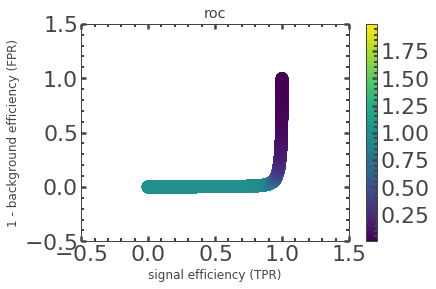

/tmp/ipykernel_29426/137454991.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  invs_back_eff = list(map(lambda x: np.log10(1 / x) if x != 1 else 0, pfn_fp)) # Q-when fpr = 1 => 1/background efficiency -> inf, what does that mean? all possitives are rejected?


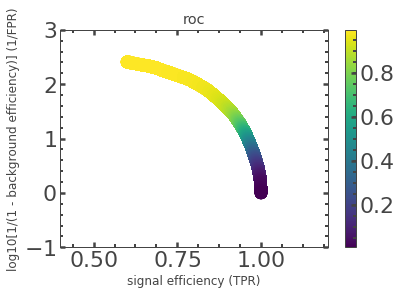

In [29]:
# manual roc curve
print(np.array(df["targets_class"]))
print(np.array(df["outputs_class"]))
pfn_fp, pfn_tp, threshs = roc_curve(df["targets_class"], df["outputs_class"])

# 1) 1 - background efficiency vs signal efficiency
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.scatter(pfn_tp, pfn_fp, c=threshs)
plt.colorbar()
plt.title('roc')
plt.ylabel('1 - background efficiency (FPR)')
plt.xlabel('signal efficiency (TPR)')
plt.show()

# 2) signal efficiency vs 1/background efficiency (1/[1-fpr])
invs_back_eff = list(map(lambda x: np.log10(1 / x) if x != 1 else 0, pfn_fp)) # Q-when fpr = 1 => 1/background efficiency -> inf, what does that mean? all possitives are rejected?

# filter out all singal efficiencies < 0.6
sig_effs = []
rejects = []
thresholds = []
for i, sig_eff in enumerate(pfn_tp):
    if sig_eff > 0.6:
        sig_effs.append(sig_eff)
        rejects.append(invs_back_eff[i])
        thresholds.append(threshs[i])
        
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.scatter(sig_effs, rejects, c=thresholds)
plt.colorbar()
plt.title('roc')
plt.xlabel('signal efficiency (TPR)')
plt.ylabel('log10[1/(1 - background efficiency)] (1/FPR)')
plt.show()